In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/

# 他社債務(60か月)

## 参考
https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering

## モジュールとCSVの読み込み

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15978370424093797805
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9399762944
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5154462755391415766
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:22:00.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 1745276110
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11827131649459587965
 physical_device_desc: "device: 1, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 2144165316]

In [4]:
import torch
# GPUの名称、CUDA Compute Capabilityを取得
print(torch.cuda.get_device_name())

NVIDIA RTX A2000 Laptop GPU


In [5]:
import pandas as pd
#import pandas_profiling
import numpy as np
import cupy as cp
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


from six import StringIO

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats
import numpy as np
import optuna.integration.lightgbm as lgb
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import feature_column
from tensorflow.keras import layers

print("OK\n")

OK



In [6]:
app_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train.csv')
app_test_origin =  pd.read_csv('./home-credit-default-risk/exports/app_test.csv')
bureau_origin = pd.read_csv('./home-credit-default-risk/bureau.csv')
bureau_balance_origin = pd.read_csv('./home-credit-default-risk/bureau_balance.csv')
app_br_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train_br_all-domein_60-monthes.csv')
app_br_test_origin = pd.read_csv('./home-credit-default-risk/exports/app_test_br_all-domein_60-monthes.csv')
#POS_CASH_balance_origin = pd.read_csv('./home-credit-default-risk/POS_CASH_balance.csv')
#credit_card_balance_origin = pd.read_csv('./home-credit-default-risk/credit_card_balance.csv')
#previous_application_origin = pd.read_csv('./home-credit-default-risk/previous_application.csv')
#installments_payments_origin = pd.read_csv('./home-credit-default-risk/installments_payments.csv')
# custo data
#app_br_train_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_Loan_From_other_banks_cash-consumer-loans.csv')
#app_br_test_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_Loan_From_other_banks_cash-consumer-loans.csv')
#app_train_br_overdue_hist_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_br_overdue_hist.csv')
#app_test_br_overdue_hist_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_br_overdue_hist.csv')
#app_train_br_debt_credit_ratio_none_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_br_debt_credit_ratio_none.csv')
#app_test_br_debt_credit_ratio_none_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_br_debt_credit_ratio_none.csv')

app_train_origin.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100002,1,0,1,0,0,202500.0,406597.5,24700.5,351000.0,...,0,0.0,1.0,0.060749,-0.067329,16.461104,False,1.158397,-55597.5,-25.920548
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0.0,0.0,0.027598,-0.070862,36.234085,False,1.145199,-164002.5,-45.931507
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0.0,0.0,0.050000,-0.011814,20.000000,False,1.000000,0.0,-52.180822
3,100006,0,0,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0,NaN,NaN,0.094941,-0.159905,10.532818,False,1.052803,-15682.5,-52.068493
4,100007,0,0,1,0,0,121500.0,513000.0,21865.5,513000.0,...,0,0.0,0.0,0.042623,-0.152418,23.461618,False,1.000000,0.0,-54.608219


## applicationの欠損値を補完

In [7]:
# applicationの欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
app_train_origin_replace = pd.DataFrame(imputer.fit_transform(app_train_origin[replace_columns].copy()), columns=replace_columns)
app_test_origin_replace = pd.DataFrame(imputer.fit_transform(app_test_origin[replace_columns].copy()), columns=replace_columns)
app_test_origin_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027


In [8]:
# 欠損値を補完した列を再結合
app_train_origin[replace_columns] = app_train_origin_replace[replace_columns]
app_test_origin[replace_columns] = app_test_origin_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [9]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


## OriginデータのCOPY

In [10]:
app_train = app_train_origin.copy()
app_test = app_test_origin.copy()
bureau = bureau_origin.copy()
bureau_balance = bureau_balance_origin.copy()
app_br_train = app_br_train_origin.copy()
app_br_test = app_br_test_origin.copy()
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [11]:
app_br_train = app_br_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_br_test = app_br_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

42311

## 共通メソッド定義

In [12]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

## 他金融機関での借り入れ情報(bureau)前処理

In [13]:
len(app_train)

307511

In [14]:
len(app_test)

48744

In [15]:
len(app_br_train)

91932

In [16]:
len(app_br_test)

42311

In [17]:
#app_train = app_train[['SK_ID_CURR','TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
#app_test = app_test[['SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
#app_train = app_train[['SK_ID_CURR','TARGET']].copy()
#app_test = app_test[['SK_ID_CURR']].copy()
len(app_test)

48744

In [18]:
app_br_train = app_br_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_br_test = app_br_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

42311

In [19]:
# trainへマージ
app_train = pd.merge(app_train, app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test, app_br_test, on='SK_ID_CURR', how='left')
len(app_test)

48744

In [20]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,br_min_amt_annuity,br_max_amt_annuity,br_sum_amt_annuity,br_avg_amt_annuity,br_cnt_amt_annuity,br_stddev_amt_annuity,br_stddev_pop_amt_annuity,br_var_pop_amt_annuity,br_var_samp_amt_annuity,br_variance_pop_amt_annuity
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,9364.500,212634.000,1236.244186,172.0,2794.728222,2794.728222,7.810506e+06,7.856181e+06,7.810506e+06
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,4261.500,12784.500,608.785714,21.0,1491.214363,1491.214363,2.223720e+06,2.334906e+06,2.223720e+06
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,NaN,0.000,0.000,0.000000,217.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,NaN,6562.485,443230.785,826.923106,536.0,2284.010751,2284.010751,5.216705e+06,5.226456e+06,5.216705e+06
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### br_min_credit_day_overdue

In [21]:
app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

,TARGET,br_min_credit_day_overdue
TARGET,1.000000,0.009145
br_min_credit_day_overdue,0.009145,1.000000


In [22]:
app_train['br_min_credit_day_overdue'].isnull().sum()

215579

In [23]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [24]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [25]:
# idをint型へ戻す
#app_train['SK_ID_CURR'] = app_train[["SK_ID_CURR"]].astype(int) 
#app_test['SK_ID_CURR'] = app_test[["SK_ID_CURR"]].astype(int)
#app_train.head()

In [26]:
#app_test['br_min_credit_day_overdue'].isnull().sum()

In [27]:
#app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

In [28]:
#kde_target('br_min_credit_day_overdue', app_train)

In [29]:
## Yao-Johnson変換
#num_cols = ['br_min_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_min_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

In [30]:
## 標準化
#num_cols = ['br_min_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_credit_day_overdue', 'TARGET']].corr()

In [31]:
columns = ['br_min_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_credit_day_overdue

In [32]:
app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

,TARGET,br_max_credit_day_overdue
TARGET,1.000000,0.000438
br_max_credit_day_overdue,0.000438,1.000000


In [33]:
app_train['br_max_credit_day_overdue'].isnull().sum()

215579

The correlation between br_max_credit_day_overdue and the TARGET is 0.0004
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


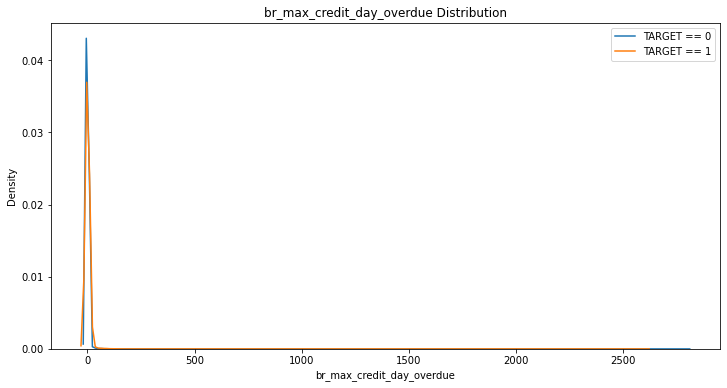

In [34]:
kde_target('br_max_credit_day_overdue', app_train)

In [35]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [36]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [37]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [38]:
#app_train['br_max_credit_day_overdue'].isnull().sum()

In [39]:
#app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

In [40]:
## Yao-Johnson変換
#num_cols = ['br_max_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_max_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [41]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

In [42]:
## 標準化
#num_cols = ['br_max_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_credit_day_overdue', 'TARGET']].corr()

In [43]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_credit_day_overdue', app_train)

In [44]:
columns = ['br_max_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_credit_day_overdue

In [45]:
app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

,TARGET,br_sum_credit_day_overdue
TARGET,1.000000,-0.002364
br_sum_credit_day_overdue,-0.002364,1.000000


In [46]:
app_train['br_sum_credit_day_overdue'].isnull().sum()

215579

The correlation between br_sum_credit_day_overdue and the TARGET is -0.0024
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


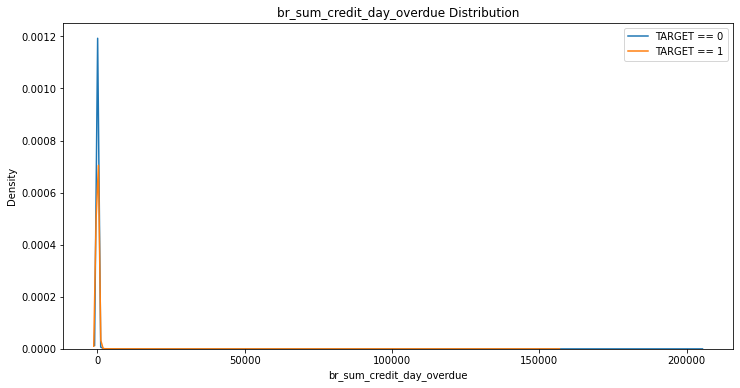

In [47]:
kde_target('br_sum_credit_day_overdue', app_train)

In [48]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_credit_day_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [49]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [50]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [51]:
#app_train['br_sum_credit_day_overdue'].isnull().sum()

In [52]:
#app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

In [53]:
## Yao-Johnson変換
#num_cols = ['br_sum_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_sum_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

In [54]:
## 標準化
#num_cols = ['br_sum_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_credit_day_overdue', 'TARGET']].corr()

In [55]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_credit_day_overdue', app_train)

In [56]:
columns = ['br_sum_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_credit_day_overdue

In [57]:
app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

,TARGET,br_avg_credit_day_overdue
TARGET,1.000000,0.003352
br_avg_credit_day_overdue,0.003352,1.000000


In [58]:
app_train['br_avg_credit_day_overdue'].isnull().sum()

215579

The correlation between br_avg_credit_day_overdue and the TARGET is 0.0034
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


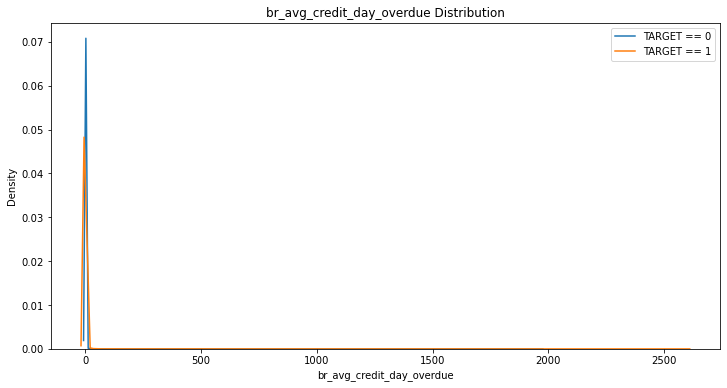

In [59]:
kde_target('br_avg_credit_day_overdue', app_train)

In [60]:
app_train['br_avg_credit_day_overdue'].isnull().sum()

215579

In [61]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_avg_credit_day_overdue')
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [62]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [63]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [64]:
#app_train['br_avg_credit_day_overdue'].isnull().sum()

In [65]:
#app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

In [66]:
## Yao-Johnson変換
#num_cols = ['br_avg_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_avg_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [67]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

In [68]:
## 標準化
#num_cols = ['br_avg_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_avg_credit_day_overdue', 'TARGET']].corr()

In [69]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_credit_day_overdue', app_train)

In [70]:
columns = ['br_avg_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_cnt_credit_day_overdue

In [71]:
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

,TARGET,br_cnt_credit_day_overdue
TARGET,1.000000,-0.040412
br_cnt_credit_day_overdue,-0.040412,1.000000


The correlation between br_cnt_credit_day_overdue and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


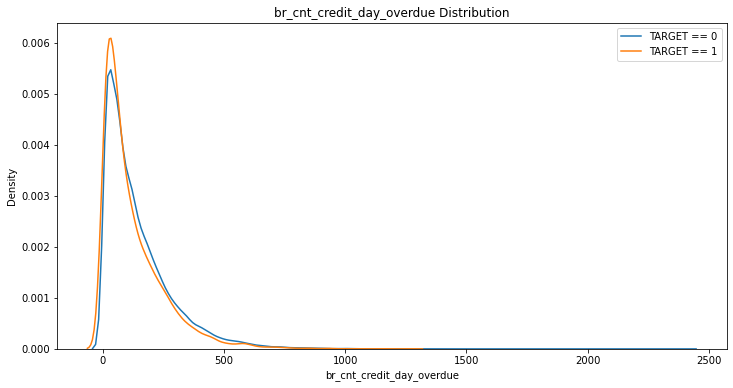

In [72]:
kde_target('br_cnt_credit_day_overdue', app_train)

In [73]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_cnt_credit_day_overdue
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,172.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,21.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,217.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,536.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,192.700818


In [74]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [75]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [76]:
app_train['br_cnt_credit_day_overdue'].isnull().sum()

0

In [77]:
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

,TARGET,br_cnt_credit_day_overdue
TARGET,1.000000,-0.048315
br_cnt_credit_day_overdue,-0.048315,1.000000


In [78]:
## Yao-Johnson変換
num_cols = ['br_cnt_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

,TARGET,br_cnt_credit_day_overdue
TARGET,1.000000,-0.061147
br_cnt_credit_day_overdue,-0.061147,1.000000


In [79]:
## 標準化
num_cols = ['br_cnt_credit_day_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_credit_day_overdue', 'TARGET']].corr()

,br_cnt_credit_day_overdue,TARGET
br_cnt_credit_day_overdue,1.000000,-0.061147
TARGET,-0.061147,1.000000


The correlation between br_cnt_credit_day_overdue and the TARGET is -0.0611
Median value for loan that was not repaid = -0.1318
Median value for loan that was repaid =     0.0741


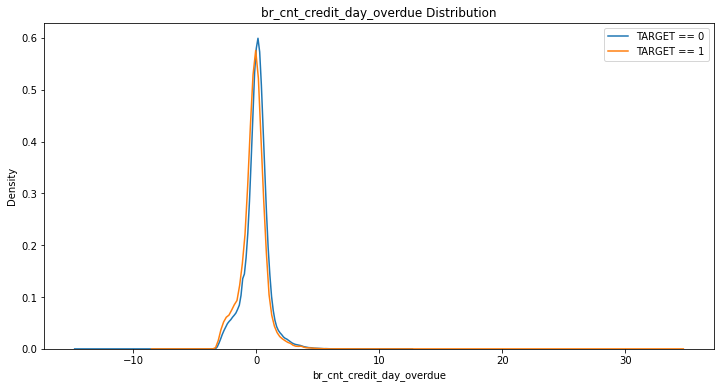

In [80]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_credit_day_overdue', app_train)

### br_stddev_credit_day_overdue

In [81]:
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

,TARGET,br_stddev_credit_day_overdue
TARGET,1.00000,-0.00256
br_stddev_credit_day_overdue,-0.00256,1.00000


In [82]:
app_train['br_stddev_credit_day_overdue'].isnull().sum()

215579

The correlation between br_stddev_credit_day_overdue and the TARGET is -0.0026
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


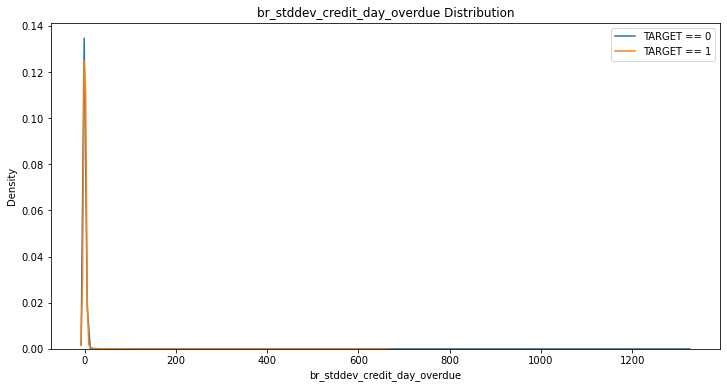

In [83]:
kde_target('br_stddev_credit_day_overdue', app_train)

In [84]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_stddev_credit_day_overdue
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,0.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,0.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,0.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,0.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,0.717279


In [85]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [86]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [87]:
app_train['br_stddev_credit_day_overdue'].isnull().sum()

0

In [88]:
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

,TARGET,br_stddev_credit_day_overdue
TARGET,1.000000,-0.003967
br_stddev_credit_day_overdue,-0.003967,1.000000


In [89]:
## Yao-Johnson変換
num_cols = ['br_stddev_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

,TARGET,br_stddev_credit_day_overdue
TARGET,1.000000,-0.012694
br_stddev_credit_day_overdue,-0.012694,1.000000


In [90]:
## 標準化
num_cols = ['br_stddev_credit_day_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_credit_day_overdue', 'TARGET']].corr()

,br_stddev_credit_day_overdue,TARGET
br_stddev_credit_day_overdue,1.000000,-0.012694
TARGET,-0.012694,1.000000


The correlation between br_stddev_credit_day_overdue and the TARGET is -0.0127
Median value for loan that was not repaid = -0.0550
Median value for loan that was repaid =     -0.0044


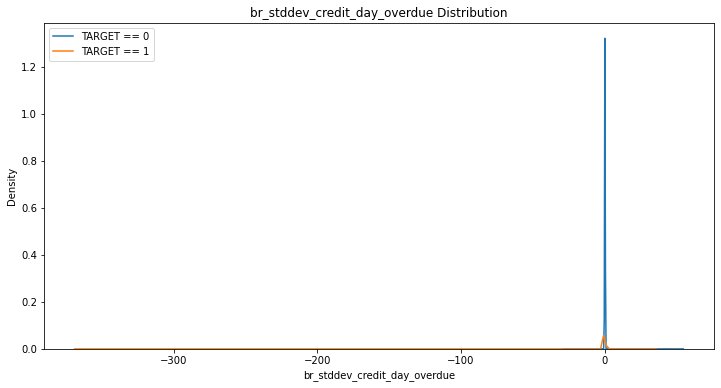

In [91]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_credit_day_overdue', app_train)

### br_stddev_pop_credit_day_overdue

In [92]:
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

,TARGET,br_stddev_pop_credit_day_overdue
TARGET,1.00000,-0.00256
br_stddev_pop_credit_day_overdue,-0.00256,1.00000


In [93]:
app_train['br_stddev_pop_credit_day_overdue'].isnull().sum()

215579

The correlation between br_stddev_pop_credit_day_overdue and the TARGET is -0.0026
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


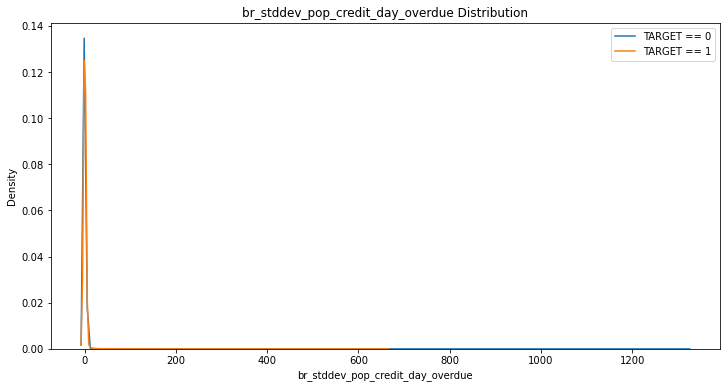

In [94]:
kde_target('br_stddev_pop_credit_day_overdue', app_train)

In [95]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_stddev_pop_credit_day_overdue
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,0.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,0.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,0.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,0.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,0.717279


In [96]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [97]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [98]:
app_train['br_stddev_pop_credit_day_overdue'].isnull().sum()

0

In [99]:
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

,TARGET,br_stddev_pop_credit_day_overdue
TARGET,1.000000,-0.003967
br_stddev_pop_credit_day_overdue,-0.003967,1.000000


In [100]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

,TARGET,br_stddev_pop_credit_day_overdue
TARGET,1.000000,-0.012694
br_stddev_pop_credit_day_overdue,-0.012694,1.000000


In [101]:
## 標準化
num_cols = ['br_stddev_pop_credit_day_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])

The correlation between br_stddev_pop_credit_day_overdue and the TARGET is -0.0127
Median value for loan that was not repaid = -0.0550
Median value for loan that was repaid =     -0.0044


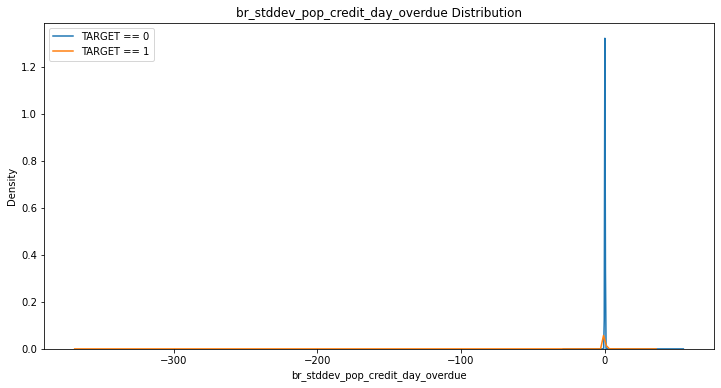

In [102]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_credit_day_overdue', app_train)

### br_var_pop_credit_day_overdue

In [103]:
app_train[['TARGET', 'br_var_pop_credit_day_overdue']].corr()

,TARGET,br_var_pop_credit_day_overdue
TARGET,1.000000,-0.004867
br_var_pop_credit_day_overdue,-0.004867,1.000000


In [104]:
app_train['br_var_pop_credit_day_overdue'].isnull().sum()

215579

The correlation between br_var_pop_credit_day_overdue and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


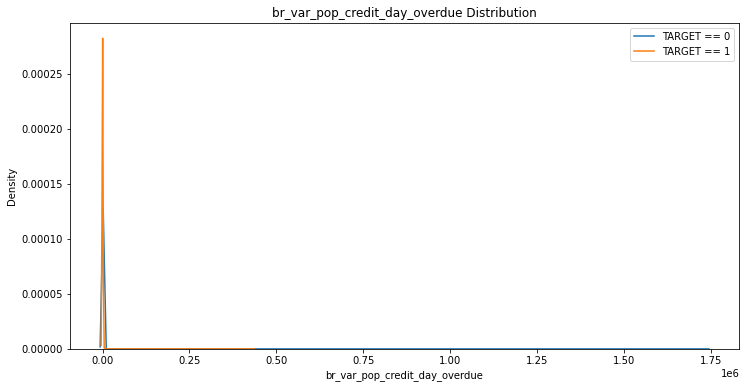

In [105]:
kde_target('br_var_pop_credit_day_overdue', app_train)

In [106]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [107]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [108]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [109]:
app_train['br_var_pop_credit_day_overdue'].isnull().sum()

215579

In [110]:
app_train[['TARGET', 'br_var_pop_credit_day_overdue']].corr()

,TARGET,br_var_pop_credit_day_overdue
TARGET,1.000000,-0.004867
br_var_pop_credit_day_overdue,-0.004867,1.000000


In [111]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [112]:
## 標準化
#num_cols = ['br_var_pop_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_credit_day_overdue', 'TARGET']].corr()

In [113]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_credit_day_overdue', app_train)

In [114]:
columns = ['br_var_pop_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_credit_day_overdue

In [115]:
app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

,TARGET,br_var_samp_credit_day_overdue
TARGET,1.000000,-0.004863
br_var_samp_credit_day_overdue,-0.004863,1.000000


In [116]:
app_train['br_var_samp_credit_day_overdue'].isnull().sum()

215579

The correlation between br_var_samp_credit_day_overdue and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


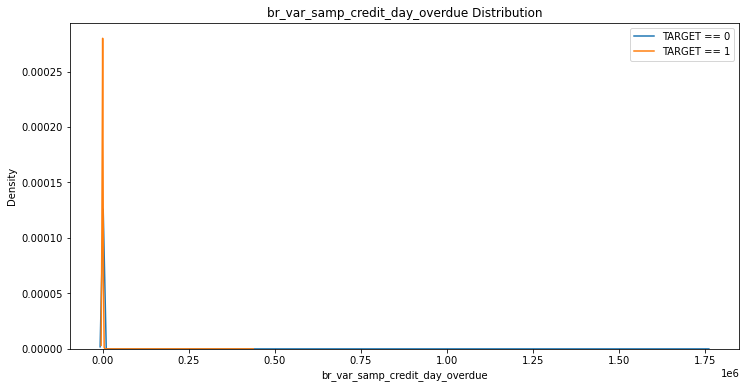

In [117]:
kde_target('br_var_samp_credit_day_overdue', app_train)

In [118]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [119]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [120]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [121]:
#app_train['br_var_samp_credit_day_overdue'].isnull().sum()

In [122]:
#app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

In [123]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [124]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

In [125]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_credit_day_overdue', app_train)

In [126]:
columns = ['br_var_samp_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_credit_day_overdue

In [127]:
app_train[['TARGET', 'br_variance_pop_credit_day_overdue']].corr()

,TARGET,br_variance_pop_credit_day_overdue
TARGET,1.000000,-0.004867
br_variance_pop_credit_day_overdue,-0.004867,1.000000


In [128]:
app_train['br_variance_pop_credit_day_overdue'].isnull().sum()

215579

The correlation between br_variance_pop_credit_day_overdue and the TARGET is -0.0049
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


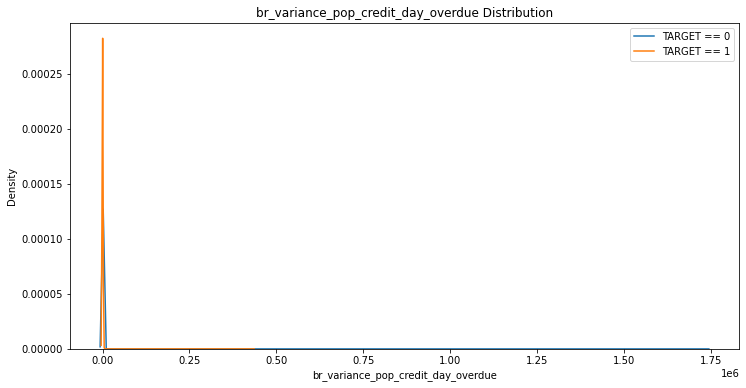

In [129]:
kde_target('br_variance_pop_credit_day_overdue', app_train)

In [130]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_variance_pop_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [131]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [132]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [133]:
#app_train['br_variance_pop_credit_day_overdue'].isnull().sum()

In [134]:
#app_train[['TARGET', 'br_variance_pop_credit_day_overdue']].corr()

In [135]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [136]:
## 標準化
#num_cols = ['br_variance_pop_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_credit_day_overdue', 'TARGET']].corr()

In [137]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_credit_day_overdue', app_train)

In [138]:
columns = ['br_variance_pop_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_min_days_credit_enddate

In [139]:
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

,TARGET,br_min_days_credit_enddate
TARGET,1.000000,0.037033
br_min_days_credit_enddate,0.037033,1.000000


In [140]:
app_train['br_min_days_credit_enddate'].isnull().sum()

215579

The correlation between br_min_days_credit_enddate and the TARGET is 0.0370
Median value for loan that was not repaid = -843.0000
Median value for loan that was repaid =     -1117.0000


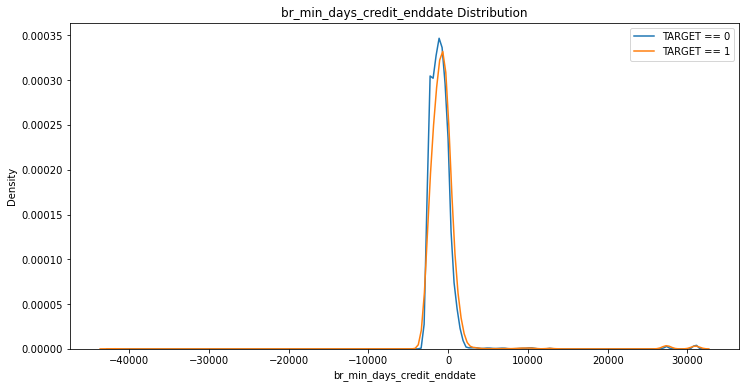

In [141]:
kde_target('br_min_days_credit_enddate', app_train)

In [142]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_days_credit_enddate')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_min_days_credit_enddate
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,-1329.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,-128.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,-1707.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,-1862.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,-1023.565976


In [143]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [144]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [145]:
app_train['br_min_days_credit_enddate'].isnull().sum()

0

In [146]:
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

,TARGET,br_min_days_credit_enddate
TARGET,1.000000,0.040183
br_min_days_credit_enddate,0.040183,1.000000


In [147]:
## Yao-Johnson変換
num_cols = ['br_min_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_min_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [148]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

,TARGET,br_min_days_credit_enddate
TARGET,1.000000,0.065153
br_min_days_credit_enddate,0.065153,1.000000


The correlation between br_min_days_credit_enddate and the TARGET is 0.0652
Median value for loan that was not repaid = 0.3099
Median value for loan that was repaid =     0.0384


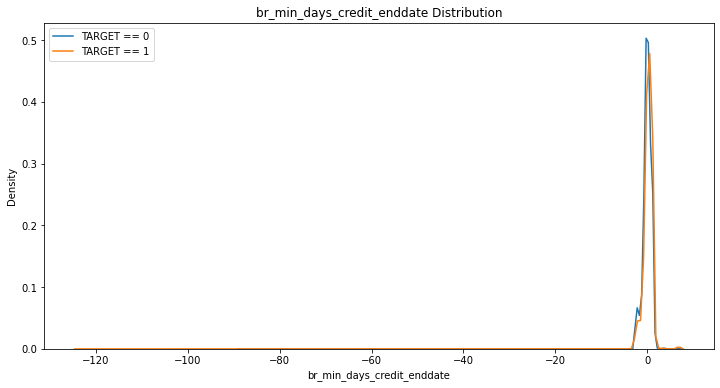

In [149]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_credit_enddate', app_train)

### br_max_days_credit_enddate

In [150]:
app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

,TARGET,br_max_days_credit_enddate
TARGET,1.000000,0.036183
br_max_days_credit_enddate,0.036183,1.000000


In [151]:
app_train['br_max_days_credit_enddate'].isnull().sum()

215579

The correlation between br_max_days_credit_enddate and the TARGET is 0.0362
Median value for loan that was not repaid = 1114.0000
Median value for loan that was repaid =     924.0000


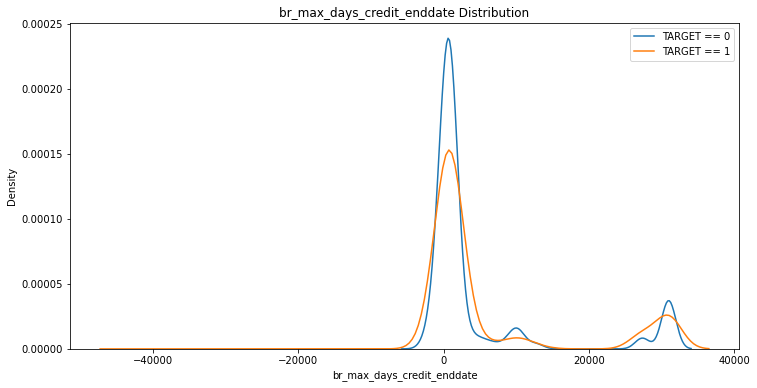

In [152]:
kde_target('br_max_days_credit_enddate', app_train)

In [153]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_days_credit_enddate')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_max_days_credit_enddate
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,1778.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,1324.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,-567.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,30885.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,5406.274462


In [154]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [155]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [156]:
app_train['br_max_days_credit_enddate'].isnull().sum()

0

In [157]:
app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

,TARGET,br_max_days_credit_enddate
TARGET,1.000000,0.026057
br_max_days_credit_enddate,0.026057,1.000000


In [158]:
## Yao-Johnson変換
num_cols = ['br_max_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_max_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

,TARGET,br_max_days_credit_enddate
TARGET,1.000000,0.026247
br_max_days_credit_enddate,0.026247,1.000000


In [159]:
## 標準化
num_cols = ['br_max_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_days_credit_enddate', 'TARGET']].corr()

,br_max_days_credit_enddate,TARGET
br_max_days_credit_enddate,1.000000,0.026247
TARGET,0.026247,1.000000


The correlation between br_max_days_credit_enddate and the TARGET is 0.0262
Median value for loan that was not repaid = 0.0882
Median value for loan that was repaid =     0.0422


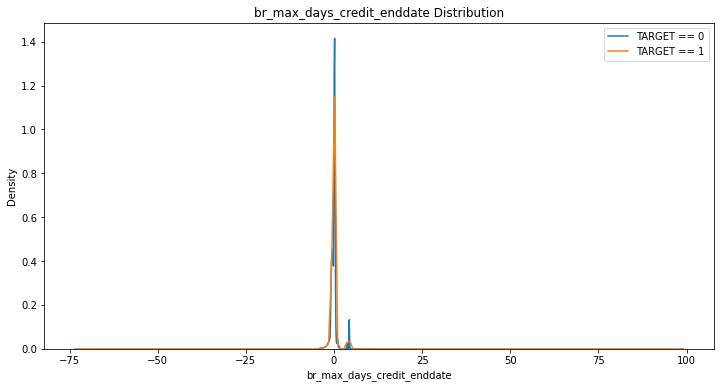

In [160]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_credit_enddate', app_train)

The correlation between br_max_days_credit_enddate and the TARGET is 0.0262
Median value for loan that was not repaid = 0.0882
Median value for loan that was repaid =     0.0422


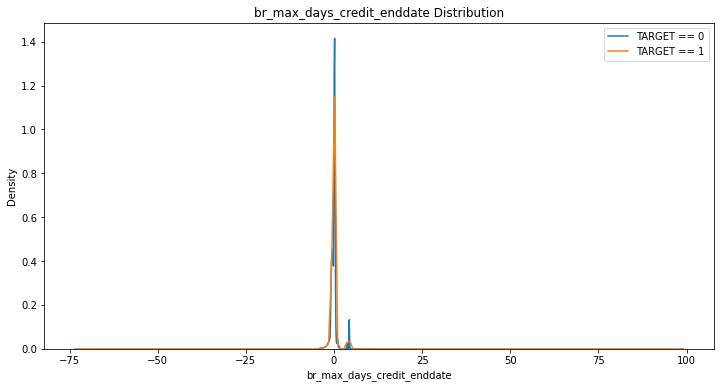

In [161]:
kde_target('br_max_days_credit_enddate', app_train)

### br_sum_days_credit_enddate

In [162]:
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

,TARGET,br_sum_days_credit_enddate
TARGET,1.000000,0.024731
br_sum_days_credit_enddate,0.024731,1.000000


In [163]:
app_train['br_sum_days_credit_enddate'].isnull().sum()

215579

The correlation between br_sum_days_credit_enddate and the TARGET is 0.0247
Median value for loan that was not repaid = 11.0000
Median value for loan that was repaid =     -12434.0000


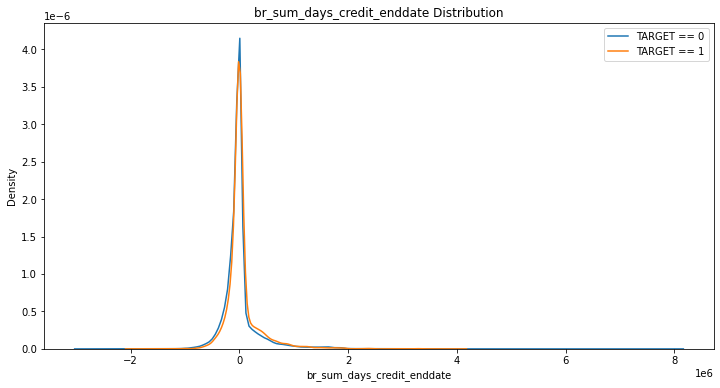

In [164]:
kde_target('br_sum_days_credit_enddate', app_train)

In [165]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_sum_days_credit_enddate
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,-7.843700e+04
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,5.322000e+03
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,-2.343210e+05
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,1.382079e+06
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,2.547419e+04


In [166]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [167]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [168]:
app_train['br_sum_days_credit_enddate'].isnull().sum()

0

In [169]:
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

,TARGET,br_sum_days_credit_enddate
TARGET,1.000000,0.021651
br_sum_days_credit_enddate,0.021651,1.000000


In [170]:
## Yao-Johnson変換
num_cols = ['br_sum_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

,TARGET,br_sum_days_credit_enddate
TARGET,1.000000,0.027587
br_sum_days_credit_enddate,0.027587,1.000000


In [171]:
## 標準化
num_cols = ['br_sum_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_days_credit_enddate', 'TARGET']].corr()

,br_sum_days_credit_enddate,TARGET
br_sum_days_credit_enddate,1.000000,0.027587
TARGET,0.027587,1.000000


The correlation between br_sum_days_credit_enddate and the TARGET is 0.0276
Median value for loan that was not repaid = 0.1102
Median value for loan that was repaid =     0.0703


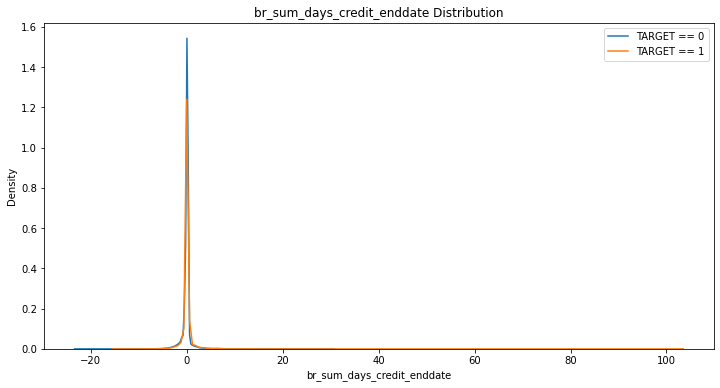

In [172]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_credit_enddate', app_train)

### br_avg_days_credit_enddate

In [173]:
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

,TARGET,br_avg_days_credit_enddate
TARGET,1.000000,0.043261
br_avg_days_credit_enddate,0.043261,1.000000


In [174]:
app_train['br_avg_days_credit_enddate'].isnull().sum()

215579

The correlation between br_avg_days_credit_enddate and the TARGET is 0.0433
Median value for loan that was not repaid = 2.1707
Median value for loan that was repaid =     -224.0000


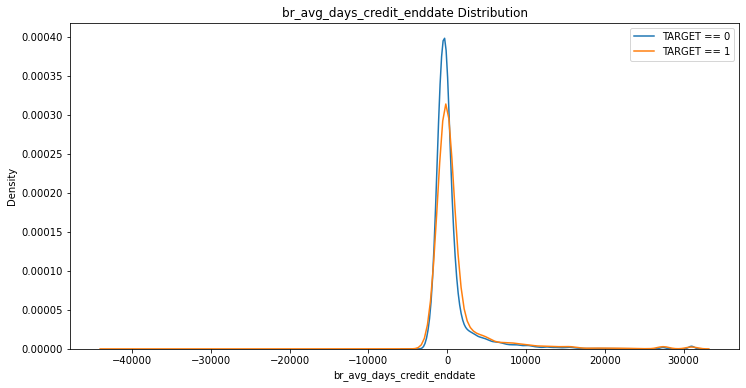

In [175]:
kde_target('br_avg_days_credit_enddate', app_train)

In [176]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_avg_days_credit_enddate
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,-456.029100
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,253.428600
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,-1079.820300
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,2820.569400
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,474.699933


In [177]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [178]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [179]:
app_train['br_avg_days_credit_enddate'].isnull().sum()

0

In [180]:
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

,TARGET,br_avg_days_credit_enddate
TARGET,1.000000,0.040887
br_avg_days_credit_enddate,0.040887,1.000000


In [181]:
## Yao-Johnson変換
num_cols = ['br_avg_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

,TARGET,br_avg_days_credit_enddate
TARGET,1.000000,0.046157
br_avg_days_credit_enddate,0.046157,1.000000


In [182]:
## 標準化
num_cols = ['br_avg_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_days_credit_enddate', 'TARGET']].corr()

,br_avg_days_credit_enddate,TARGET
br_avg_days_credit_enddate,1.000000,0.046157
TARGET,0.046157,1.000000


The correlation between br_avg_days_credit_enddate and the TARGET is 0.0462
Median value for loan that was not repaid = 0.1924
Median value for loan that was repaid =     0.0968


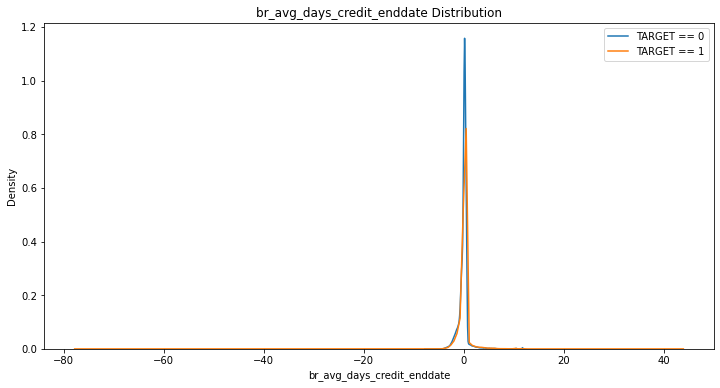

In [183]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_credit_enddate', app_train)

### br_cnt_days_credit_enddate

In [184]:
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

,TARGET,br_cnt_days_credit_enddate
TARGET,1.000000,-0.043187
br_cnt_days_credit_enddate,-0.043187,1.000000


In [185]:
app_train['br_cnt_days_credit_enddate'].isnull().sum()

215579

The correlation between br_cnt_days_credit_enddate and the TARGET is -0.0432
Median value for loan that was not repaid = 74.0000
Median value for loan that was repaid =     96.0000


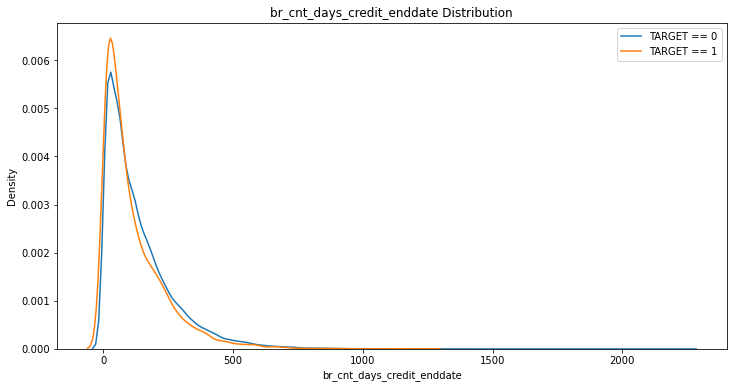

In [186]:
kde_target('br_cnt_days_credit_enddate', app_train)

In [187]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_cnt_days_credit_enddate
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,172.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,21.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,217.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,490.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,183.608154


In [188]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [189]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [190]:
app_train['br_cnt_days_credit_enddate'].isnull().sum()

0

In [191]:
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

,TARGET,br_cnt_days_credit_enddate
TARGET,1.000000,-0.051836
br_cnt_days_credit_enddate,-0.051836,1.000000


In [192]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

,TARGET,br_cnt_days_credit_enddate
TARGET,1.000000,-0.065311
br_cnt_days_credit_enddate,-0.065311,1.000000


In [193]:
## 標準化
num_cols = ['br_cnt_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_days_credit_enddate', 'TARGET']].corr()

,br_cnt_days_credit_enddate,TARGET
br_cnt_days_credit_enddate,1.000000,-0.065311
TARGET,-0.065311,1.000000


The correlation between br_cnt_days_credit_enddate and the TARGET is -0.0653
Median value for loan that was not repaid = -0.1416
Median value for loan that was repaid =     0.0786


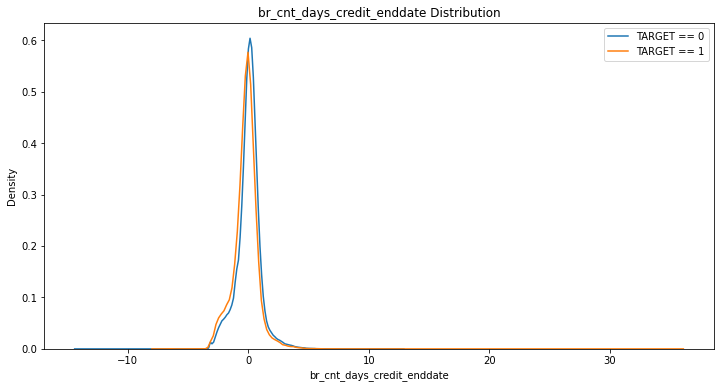

In [194]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_credit_enddate', app_train)

### br_stddev_days_credit_enddate

In [195]:
app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

,TARGET,br_stddev_days_credit_enddate
TARGET,1.000000,0.025279
br_stddev_days_credit_enddate,0.025279,1.000000


In [196]:
app_train['br_stddev_days_credit_enddate'].isnull().sum()

215579

The correlation between br_stddev_days_credit_enddate and the TARGET is 0.0253
Median value for loan that was not repaid = 667.5509
Median value for loan that was repaid =     672.7729


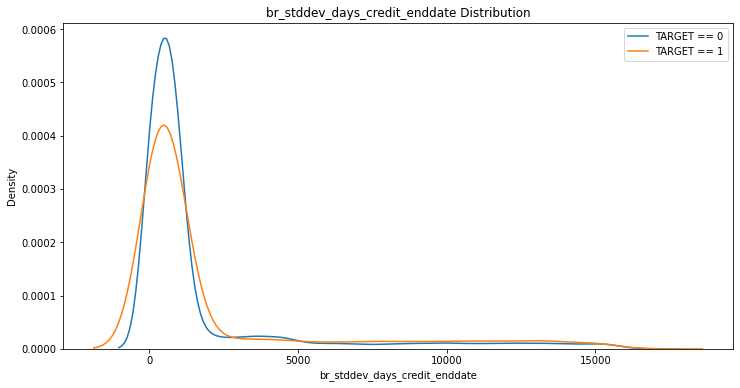

In [197]:
kde_target('br_stddev_days_credit_enddate', app_train)

In [198]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_stddev_days_credit_enddate
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,744.580906
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,604.498105
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,430.636106
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,10509.599376
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,2070.611367


In [199]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [200]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [201]:
app_train['br_stddev_days_credit_enddate'].isnull().sum()

0

In [202]:
app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

,TARGET,br_stddev_days_credit_enddate
TARGET,1.000000,0.033268
br_stddev_days_credit_enddate,0.033268,1.000000


In [203]:
## Yao-Johnson変換
#num_cols = ['br_stddev_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

In [204]:
## 標準化
num_cols = ['br_stddev_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_days_credit_enddate', 'TARGET']].corr()

,br_stddev_days_credit_enddate,TARGET
br_stddev_days_credit_enddate,1.000000,0.033268
TARGET,0.033268,1.000000


The correlation between br_stddev_days_credit_enddate and the TARGET is 0.0333
Median value for loan that was not repaid = -0.0245
Median value for loan that was repaid =     -0.1320


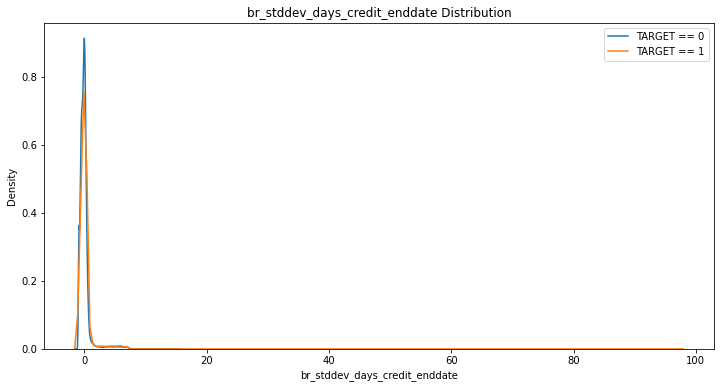

In [205]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_days_credit_enddate', app_train)

### br_stddev_pop_days_credit_enddate

In [206]:
app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

,TARGET,br_stddev_pop_days_credit_enddate
TARGET,1.000000,0.025279
br_stddev_pop_days_credit_enddate,0.025279,1.000000


In [207]:
app_train['br_stddev_pop_days_credit_enddate'].isnull().sum()

215579

The correlation between br_stddev_pop_days_credit_enddate and the TARGET is 0.0253
Median value for loan that was not repaid = 667.5509
Median value for loan that was repaid =     672.7729


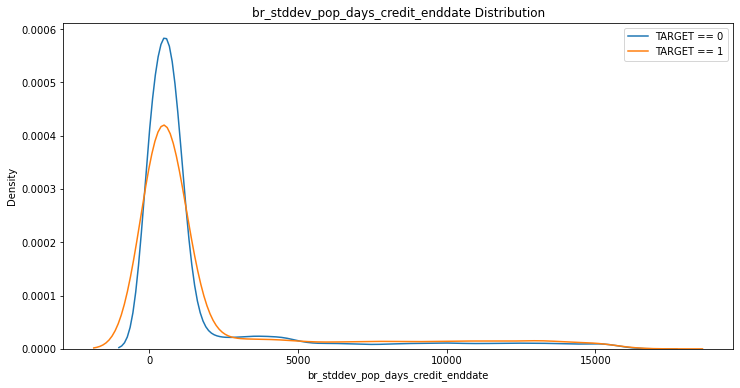

In [208]:
kde_target('br_stddev_pop_days_credit_enddate', app_train)

In [209]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_stddev_pop_days_credit_enddate
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,744.580906
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,604.498105
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,430.636106
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,10509.599376
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,2070.611367


In [210]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [211]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [212]:
app_train['br_stddev_pop_days_credit_enddate'].isnull().sum()

0

In [213]:
app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

,TARGET,br_stddev_pop_days_credit_enddate
TARGET,1.000000,0.033268
br_stddev_pop_days_credit_enddate,0.033268,1.000000


In [214]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

In [215]:
## 標準化
num_cols = ['br_stddev_pop_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_days_credit_enddate', 'TARGET']].corr()

,br_stddev_pop_days_credit_enddate,TARGET
br_stddev_pop_days_credit_enddate,1.000000,0.033268
TARGET,0.033268,1.000000


The correlation between br_stddev_pop_days_credit_enddate and the TARGET is 0.0333
Median value for loan that was not repaid = -0.0245
Median value for loan that was repaid =     -0.1320


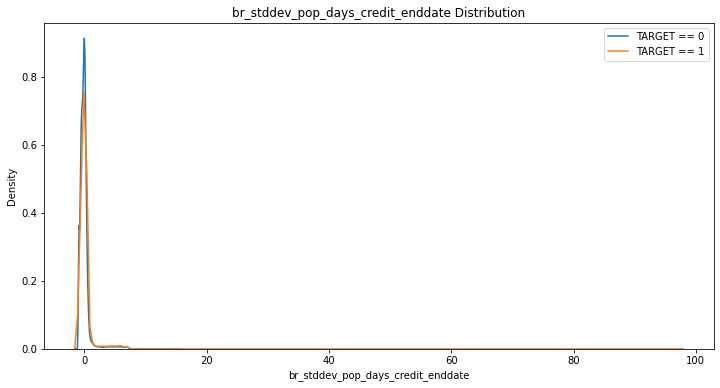

In [216]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_credit_enddate', app_train)

### br_var_pop_days_credit_enddate

In [217]:
app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

,TARGET,br_var_pop_days_credit_enddate
TARGET,1.000000,0.025917
br_var_pop_days_credit_enddate,0.025917,1.000000


In [218]:
app_train['br_var_pop_days_credit_enddate'].isnull().sum()

215579

The correlation between br_var_pop_days_credit_enddate and the TARGET is 0.0259
Median value for loan that was not repaid = 445624.1613
Median value for loan that was repaid =     452623.4119


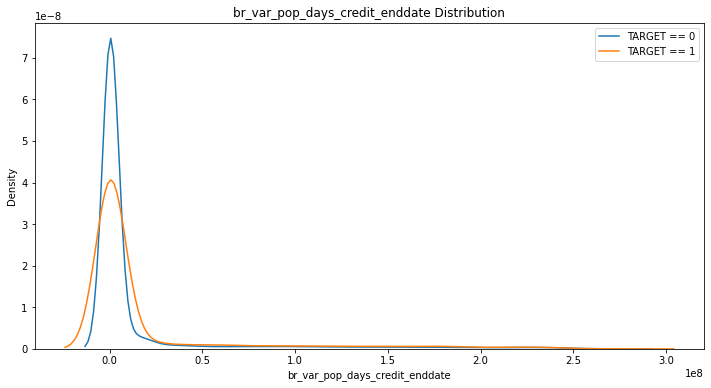

In [219]:
kde_target('br_var_pop_days_credit_enddate', app_train)

In [220]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_var_pop_days_credit_enddate
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,5.544007e+05
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,3.654180e+05
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,1.854475e+05
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,1.104517e+08
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,1.585426e+07


In [221]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [222]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [223]:
app_train['br_var_pop_days_credit_enddate'].isnull().sum()

0

In [224]:
app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

,TARGET,br_var_pop_days_credit_enddate
TARGET,1.00000,0.02152
br_var_pop_days_credit_enddate,0.02152,1.00000


In [225]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

In [226]:
## 標準化
num_cols = ['br_var_pop_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_days_credit_enddate', 'TARGET']].corr()

,br_var_pop_days_credit_enddate,TARGET
br_var_pop_days_credit_enddate,1.00000,0.02152
TARGET,0.02152,1.00000


The correlation between br_var_pop_days_credit_enddate and the TARGET is 0.0215
Median value for loan that was not repaid = 0.0020
Median value for loan that was repaid =     -0.0382


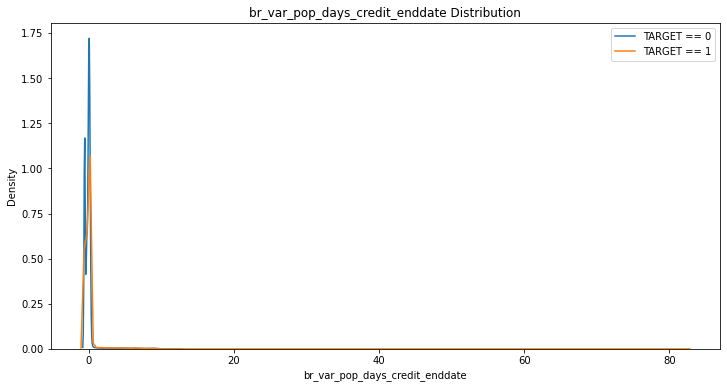

In [227]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_credit_enddate', app_train)

### br_var_samp_days_credit_enddate

In [228]:
app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

,TARGET,br_var_samp_days_credit_enddate
TARGET,1.000000,0.026529
br_var_samp_days_credit_enddate,0.026529,1.000000


In [229]:
app_train['br_var_samp_days_credit_enddate'].isnull().sum()

215579

The correlation between br_var_samp_days_credit_enddate and the TARGET is 0.0265
Median value for loan that was not repaid = 451188.8648
Median value for loan that was repaid =     458383.1710


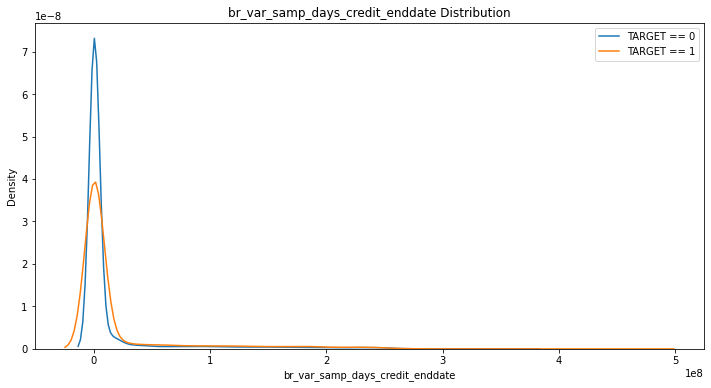

In [230]:
kde_target('br_var_samp_days_credit_enddate', app_train)

In [231]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_days_credit_enddate')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_var_samp_days_credit_enddate
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,5.576428e+05
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,3.836889e+05
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,1.863060e+05
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,1.106776e+08
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,1.599523e+07


In [232]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [233]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [234]:
app_train['br_var_samp_days_credit_enddate'].isnull().sum()

0

In [235]:
app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

,TARGET,br_var_samp_days_credit_enddate
TARGET,1.000000,0.022111
br_var_samp_days_credit_enddate,0.022111,1.000000


In [236]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

In [237]:
## 標準化
num_cols = ['br_var_samp_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_days_credit_enddate', 'TARGET']].corr()

,br_var_samp_days_credit_enddate,TARGET
br_var_samp_days_credit_enddate,1.000000,0.022111
TARGET,0.022111,1.000000


The correlation between br_var_samp_days_credit_enddate and the TARGET is 0.0221
Median value for loan that was not repaid = 0.0024
Median value for loan that was repaid =     -0.0392


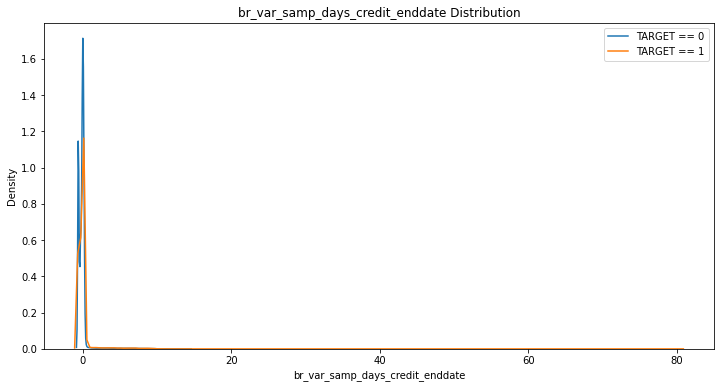

In [238]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_credit_enddate', app_train)

### br_variance_pop_days_credit_enddate

In [239]:
app_train[['TARGET', 'br_variance_pop_days_credit_enddate']].corr()

,TARGET,br_variance_pop_days_credit_enddate
TARGET,1.000000,0.025917
br_variance_pop_days_credit_enddate,0.025917,1.000000


In [240]:
app_train['br_variance_pop_days_credit_enddate'].isnull().sum()

215579

The correlation between br_variance_pop_days_credit_enddate and the TARGET is 0.0259
Median value for loan that was not repaid = 445624.1613
Median value for loan that was repaid =     452623.4119


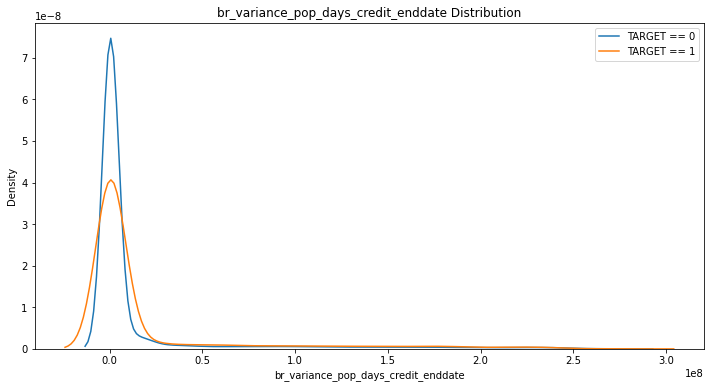

In [241]:
kde_target('br_variance_pop_days_credit_enddate', app_train)

In [242]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_days_credit_enddate')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_variance_pop_days_credit_enddate
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,5.544007e+05
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,3.654180e+05
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,1.854475e+05
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,1.104517e+08
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,1.585426e+07


In [243]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [244]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [245]:
app_train['br_variance_pop_days_credit_enddate'].isnull().sum()

0

In [246]:
app_train[['TARGET', 'br_variance_pop_days_credit_enddate']].corr()

,TARGET,br_variance_pop_days_credit_enddate
TARGET,1.00000,0.02152
br_variance_pop_days_credit_enddate,0.02152,1.00000


In [247]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_days_credit_enddate']].corr()

In [248]:
## 標準化
num_cols = ['br_variance_pop_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_days_credit_enddate', 'TARGET']].corr()

,br_variance_pop_days_credit_enddate,TARGET
br_variance_pop_days_credit_enddate,1.00000,0.02152
TARGET,0.02152,1.00000


The correlation between br_variance_pop_days_credit_enddate and the TARGET is 0.0215
Median value for loan that was not repaid = 0.0020
Median value for loan that was repaid =     -0.0382


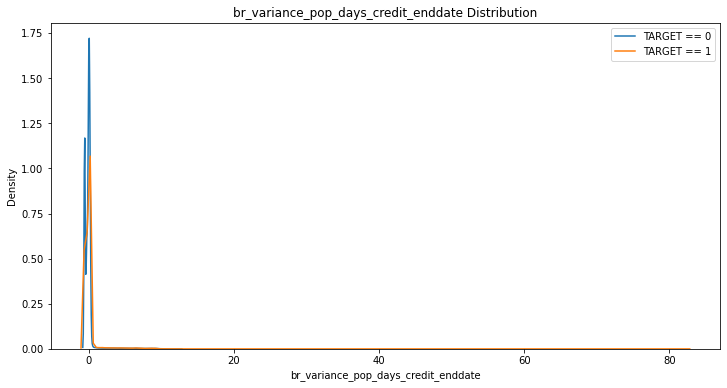

In [249]:
kde_target('br_variance_pop_days_credit_enddate', app_train)

### br_min_days_enddate_fact

In [250]:
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

,TARGET,br_min_days_enddate_fact
TARGET,1.000000,0.066363
br_min_days_enddate_fact,0.066363,1.000000


In [251]:
app_train['br_min_days_enddate_fact'].isnull().sum()

215579

The correlation between br_min_days_enddate_fact and the TARGET is 0.0664
Median value for loan that was not repaid = -885.0000
Median value for loan that was repaid =     -1141.0000


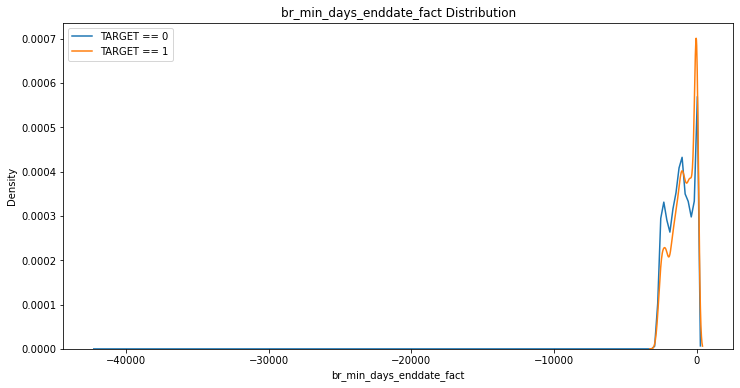

In [252]:
kde_target('br_min_days_enddate_fact', app_train)

In [253]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_min_days_enddate_fact
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,-1328.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,-123.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,-1334.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,-1862.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,-1279.823663


In [254]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [255]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [256]:
app_train['br_min_days_enddate_fact'].isnull().sum()

0

In [257]:
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

,TARGET,br_min_days_enddate_fact
TARGET,1.000000,0.090787
br_min_days_enddate_fact,0.090787,1.000000


In [258]:
## Yao-Johnson変換
num_cols = ['br_min_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_min_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

,TARGET,br_min_days_enddate_fact
TARGET,1.00000,0.09236
br_min_days_enddate_fact,0.09236,1.00000


In [259]:
## 標準化
num_cols = ['br_min_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_min_days_enddate_fact', 'TARGET']].corr()

,br_min_days_enddate_fact,TARGET
br_min_days_enddate_fact,1.00000,0.09236
TARGET,0.09236,1.00000


The correlation between br_min_days_enddate_fact and the TARGET is 0.0924
Median value for loan that was not repaid = 0.2450
Median value for loan that was repaid =     -0.1087


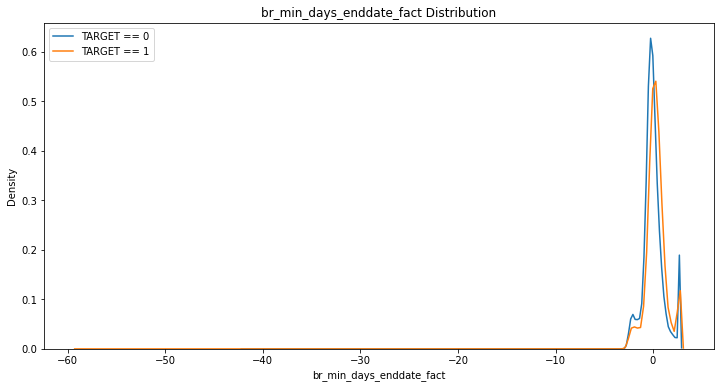

In [260]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_enddate_fact', app_train)

### br_max_days_enddate_fact

In [261]:
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

,TARGET,br_max_days_enddate_fact
TARGET,1.000000,0.035493
br_max_days_enddate_fact,0.035493,1.000000


In [262]:
app_train['br_max_days_enddate_fact'].isnull().sum()

215579

The correlation between br_max_days_enddate_fact and the TARGET is 0.0355
Median value for loan that was not repaid = -218.0000
Median value for loan that was repaid =     -272.0000


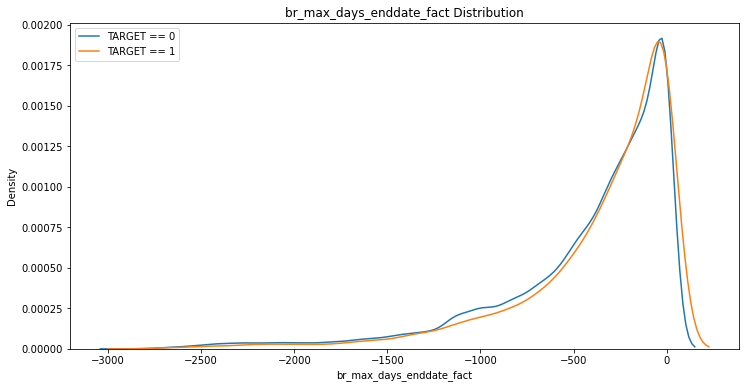

In [263]:
kde_target('br_max_days_enddate_fact', app_train)

In [264]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_max_days_enddate_fact
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,-544.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,-123.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,-549.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,-687.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,-441.385853


In [265]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [266]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [267]:
app_train['br_max_days_enddate_fact'].isnull().sum()

0

In [268]:
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

,TARGET,br_max_days_enddate_fact
TARGET,1.000000,0.065527
br_max_days_enddate_fact,0.065527,1.000000


In [269]:
## Yao-Johnson変換
num_cols = ['br_max_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_max_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

,TARGET,br_max_days_enddate_fact
TARGET,1.0000,0.0672
br_max_days_enddate_fact,0.0672,1.0000


In [270]:
## 標準化
num_cols = ['br_max_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_days_enddate_fact', 'TARGET']].corr()

,br_max_days_enddate_fact,TARGET
br_max_days_enddate_fact,1.0000,0.0672
TARGET,0.0672,1.0000


The correlation between br_max_days_enddate_fact and the TARGET is 0.0672
Median value for loan that was not repaid = 0.2566
Median value for loan that was repaid =     -0.0230


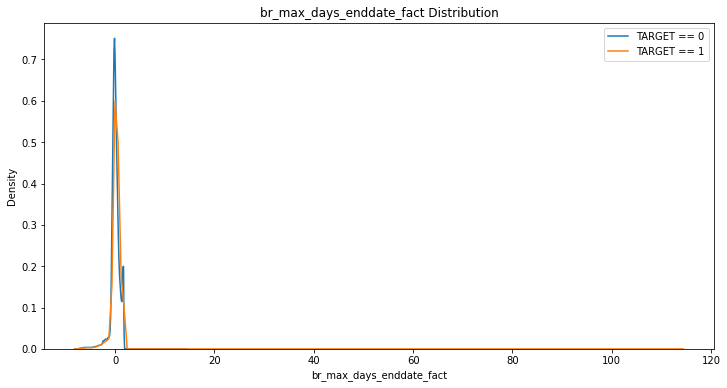

In [271]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_enddate_fact', app_train)

### br_sum_days_enddate_fact

In [272]:
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

,TARGET,br_sum_days_enddate_fact
TARGET,1.000000,0.052929
br_sum_days_enddate_fact,0.052929,1.000000


In [273]:
app_train['br_sum_days_enddate_fact'].isnull().sum()

215579

The correlation between br_sum_days_enddate_fact and the TARGET is 0.0529
Median value for loan that was not repaid = -31709.0000
Median value for loan that was repaid =     -60254.0000


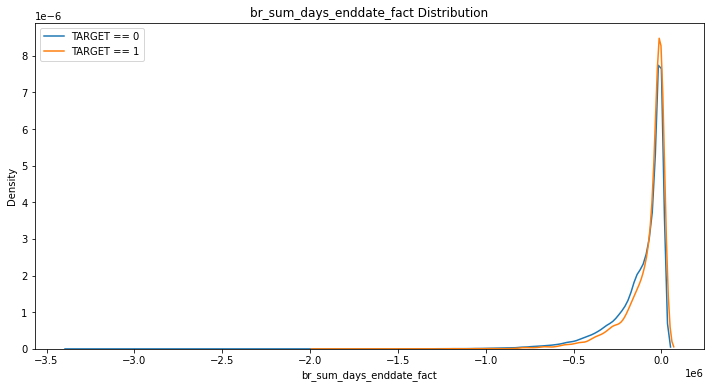

In [274]:
kde_target('br_sum_days_enddate_fact', app_train)

In [275]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_sum_days_enddate_fact
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,-127179.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,-1599.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,-230587.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,-478968.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,-199321.269562


In [276]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [277]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [278]:
app_train['br_sum_days_enddate_fact'].isnull().sum()

0

In [279]:
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

,TARGET,br_sum_days_enddate_fact
TARGET,1.000000,0.052538
br_sum_days_enddate_fact,0.052538,1.000000


In [280]:
## Yao-Johnson変換
num_cols = ['br_sum_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

,TARGET,br_sum_days_enddate_fact
TARGET,1.000000,0.057998
br_sum_days_enddate_fact,0.057998,1.000000


In [281]:
## 標準化
num_cols = ['br_sum_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_days_enddate_fact', 'TARGET']].corr()

,br_sum_days_enddate_fact,TARGET
br_sum_days_enddate_fact,1.000000,0.057998
TARGET,0.057998,1.000000


The correlation between br_sum_days_enddate_fact and the TARGET is 0.0580
Median value for loan that was not repaid = 0.1819
Median value for loan that was repaid =     -0.0122


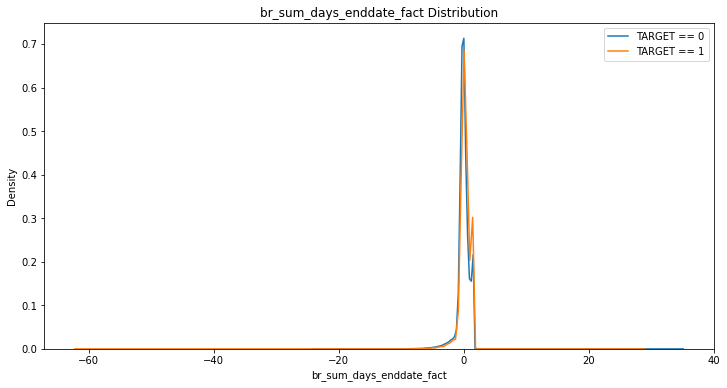

In [282]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_enddate_fact', app_train)

### br_avg_days_enddate_fact

In [283]:
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

,TARGET,br_avg_days_enddate_fact
TARGET,1.00000,0.06598
br_avg_days_enddate_fact,0.06598,1.00000


In [284]:
app_train['br_avg_days_enddate_fact'].isnull().sum()

215579

The correlation between br_avg_days_enddate_fact and the TARGET is 0.0660
Median value for loan that was not repaid = -641.5000
Median value for loan that was repaid =     -816.2619


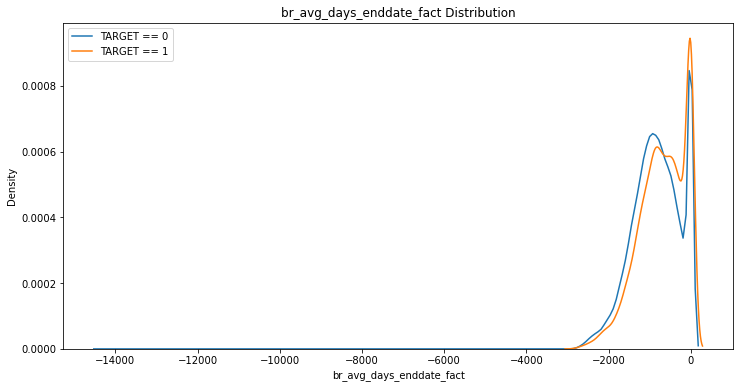

In [285]:
kde_target('br_avg_days_enddate_fact', app_train)

In [286]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_avg_days_enddate_fact
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,-908.421400
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,-123.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,-1062.612900
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,-1326.781200
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,-936.199912


In [287]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [288]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [289]:
app_train['br_avg_days_enddate_fact'].isnull().sum()

0

In [290]:
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

,TARGET,br_avg_days_enddate_fact
TARGET,1.00000,0.09681
br_avg_days_enddate_fact,0.09681,1.00000


In [291]:
## Yao-Johnson変換
num_cols = ['br_avg_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

,TARGET,br_avg_days_enddate_fact
TARGET,1.000000,0.097116
br_avg_days_enddate_fact,0.097116,1.000000


In [292]:
## 標準化
num_cols = ['br_avg_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_days_enddate_fact', 'TARGET']].corr()

,br_avg_days_enddate_fact,TARGET
br_avg_days_enddate_fact,1.000000,0.097116
TARGET,0.097116,1.000000


The correlation between br_avg_days_enddate_fact and the TARGET is 0.0971
Median value for loan that was not repaid = 0.2689
Median value for loan that was repaid =     -0.1144


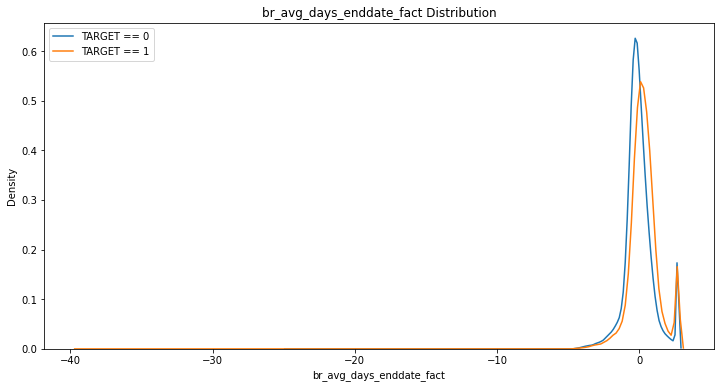

In [293]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_enddate_fact', app_train)

### br_cnt_days_enddate_fact

In [294]:
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

,TARGET,br_cnt_days_enddate_fact
TARGET,1.000000,-0.049224
br_cnt_days_enddate_fact,-0.049224,1.000000


In [295]:
app_train['br_cnt_days_enddate_fact'].isnull().sum()

215579

The correlation between br_cnt_days_enddate_fact and the TARGET is -0.0492
Median value for loan that was not repaid = 50.0000
Median value for loan that was repaid =     67.0000


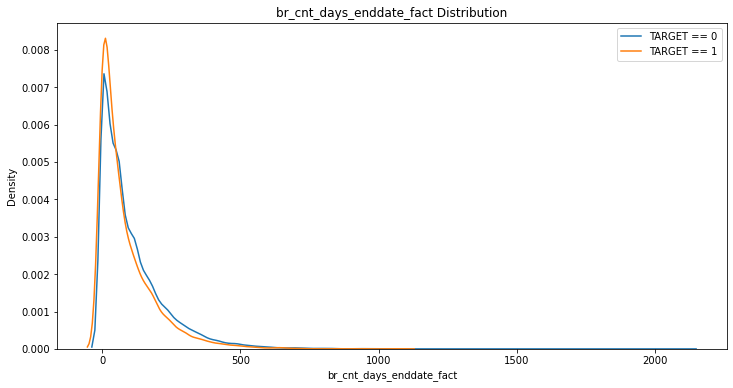

In [296]:
kde_target('br_cnt_days_enddate_fact', app_train)

In [297]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_cnt_days_enddate_fact
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,140.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,13.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,217.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,361.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,147.883987


In [298]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [299]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [300]:
app_train['br_cnt_days_enddate_fact'].isnull().sum()

0

In [301]:
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

,TARGET,br_cnt_days_enddate_fact
TARGET,1.000000,-0.060977
br_cnt_days_enddate_fact,-0.060977,1.000000


In [302]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

,TARGET,br_cnt_days_enddate_fact
TARGET,1.000000,-0.072848
br_cnt_days_enddate_fact,-0.072848,1.000000


In [303]:
## 標準化
num_cols = ['br_cnt_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_days_enddate_fact', 'TARGET']].corr()

,br_cnt_days_enddate_fact,TARGET
br_cnt_days_enddate_fact,1.000000,-0.072848
TARGET,-0.072848,1.000000


The correlation between br_cnt_days_enddate_fact and the TARGET is -0.0728
Median value for loan that was not repaid = -0.1563
Median value for loan that was repaid =     0.0910


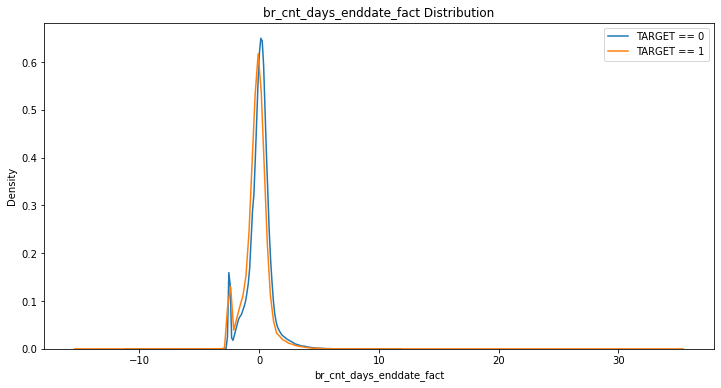

In [304]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_enddate_fact', app_train)

### br_stddev_days_enddate_fact

In [305]:
app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

,TARGET,br_stddev_days_enddate_fact
TARGET,1.000000,-0.049746
br_stddev_days_enddate_fact,-0.049746,1.000000


In [306]:
app_train['br_stddev_days_enddate_fact'].isnull().sum()

215579

The correlation between br_stddev_days_enddate_fact and the TARGET is -0.0497
Median value for loan that was not repaid = 119.0580
Median value for loan that was repaid =     220.7851


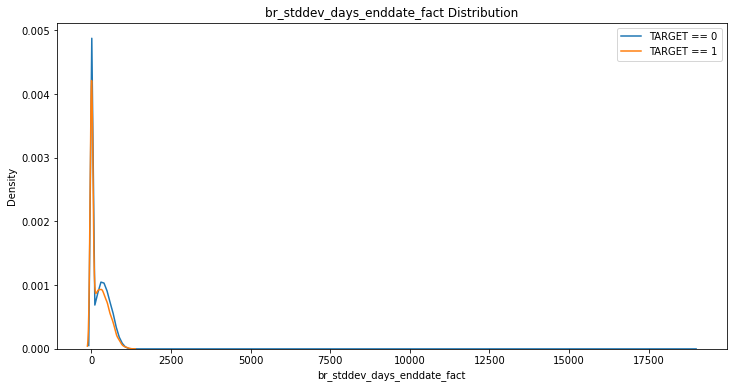

In [307]:
kde_target('br_stddev_days_enddate_fact', app_train)

In [308]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_stddev_days_enddate_fact
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,345.364343
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,0.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,308.087407
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,457.494428
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,307.337466


In [309]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [310]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [311]:
app_train['br_stddev_days_enddate_fact'].isnull().sum()

0

In [312]:
app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

,TARGET,br_stddev_days_enddate_fact
TARGET,1.000000,-0.062284
br_stddev_days_enddate_fact,-0.062284,1.000000


In [313]:
## Yao-Johnson変換
num_cols = ['br_stddev_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_stddev_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

,TARGET,br_stddev_days_enddate_fact
TARGET,1.000000,-0.065152
br_stddev_days_enddate_fact,-0.065152,1.000000


In [314]:
## 標準化
num_cols = ['br_stddev_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_days_enddate_fact', 'TARGET']].corr()

,br_stddev_days_enddate_fact,TARGET
br_stddev_days_enddate_fact,1.000000,-0.065152
TARGET,-0.065152,1.000000


The correlation between br_stddev_days_enddate_fact and the TARGET is -0.0652
Median value for loan that was not repaid = -0.0960
Median value for loan that was repaid =     0.1468


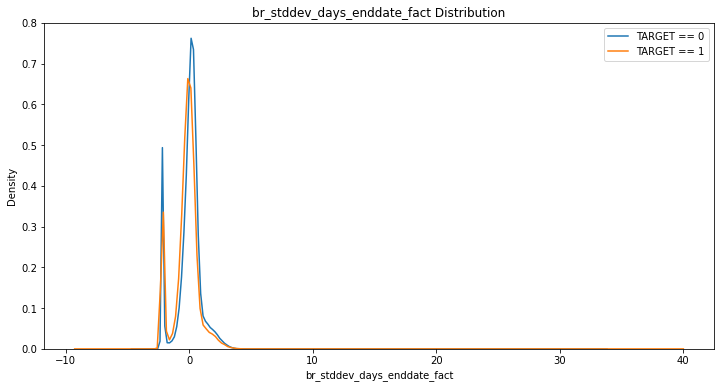

In [315]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_days_enddate_fact', app_train)

### br_stddev_pop_days_enddate_fact

In [316]:
app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

,TARGET,br_stddev_pop_days_enddate_fact
TARGET,1.000000,-0.049746
br_stddev_pop_days_enddate_fact,-0.049746,1.000000


In [317]:
app_train['br_stddev_pop_days_enddate_fact'].isnull().sum()

215579

The correlation between br_stddev_pop_days_enddate_fact and the TARGET is -0.0497
Median value for loan that was not repaid = 119.0580
Median value for loan that was repaid =     220.7851


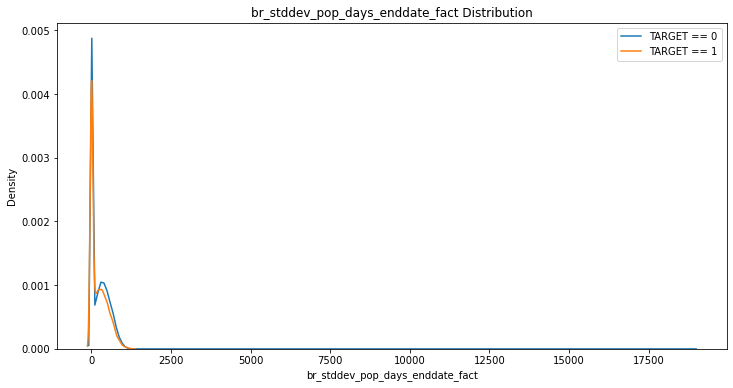

In [318]:
kde_target('br_stddev_pop_days_enddate_fact', app_train)

In [319]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_stddev_pop_days_enddate_fact
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,345.364343
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,0.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,308.087407
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,457.494428
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,307.337466


In [320]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [321]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [322]:
app_train['br_stddev_pop_days_enddate_fact'].isnull().sum()

0

In [323]:
app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

,TARGET,br_stddev_pop_days_enddate_fact
TARGET,1.000000,-0.062284
br_stddev_pop_days_enddate_fact,-0.062284,1.000000


In [324]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

,TARGET,br_stddev_pop_days_enddate_fact
TARGET,1.000000,-0.065152
br_stddev_pop_days_enddate_fact,-0.065152,1.000000


In [325]:
## 標準化
num_cols = ['br_stddev_pop_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_days_enddate_fact', 'TARGET']].corr()

,br_stddev_pop_days_enddate_fact,TARGET
br_stddev_pop_days_enddate_fact,1.000000,-0.065152
TARGET,-0.065152,1.000000


The correlation between br_stddev_pop_days_enddate_fact and the TARGET is -0.0652
Median value for loan that was not repaid = -0.0960
Median value for loan that was repaid =     0.1468


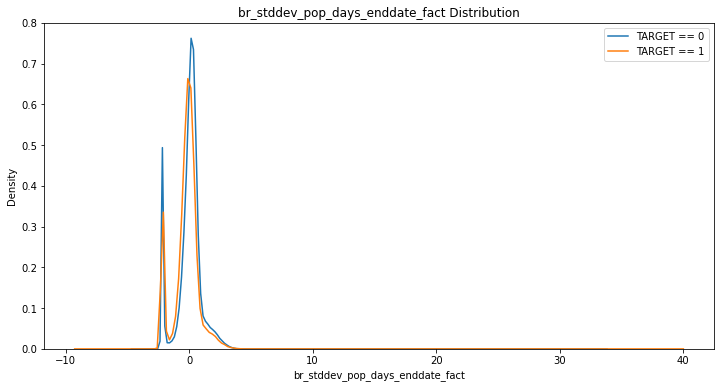

In [326]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_enddate_fact', app_train)

### br_var_pop_days_enddate_fact

In [327]:
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

,TARGET,br_var_pop_days_enddate_fact
TARGET,1.000000,-0.008187
br_var_pop_days_enddate_fact,-0.008187,1.000000


In [328]:
app_train['br_var_pop_days_enddate_fact'].isnull().sum()

215579

The correlation between br_var_pop_days_enddate_fact and the TARGET is -0.0082
Median value for loan that was not repaid = 14174.8069
Median value for loan that was repaid =     48746.0656


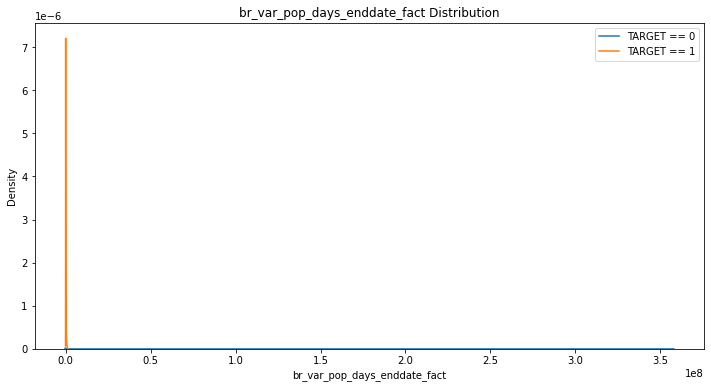

In [329]:
kde_target('br_var_pop_days_enddate_fact', app_train)

In [330]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_var_pop_days_enddate_fact
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,119276.529541
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,0.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,94917.850156
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,209301.151557
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,181424.360971


In [331]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [332]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [333]:
app_train['br_var_pop_days_enddate_fact'].isnull().sum()

0

In [334]:
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

,TARGET,br_var_pop_days_enddate_fact
TARGET,1.000000,-0.008672
br_var_pop_days_enddate_fact,-0.008672,1.000000


In [335]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

,TARGET,br_var_pop_days_enddate_fact
TARGET,1.000000,-0.049275
br_var_pop_days_enddate_fact,-0.049275,1.000000


In [336]:
## 標準化
num_cols = ['br_var_pop_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_days_enddate_fact', 'TARGET']].corr()

,br_var_pop_days_enddate_fact,TARGET
br_var_pop_days_enddate_fact,1.000000,-0.049275
TARGET,-0.049275,1.000000


The correlation between br_var_pop_days_enddate_fact and the TARGET is -0.0493
Median value for loan that was not repaid = 0.0076
Median value for loan that was repaid =     0.1744


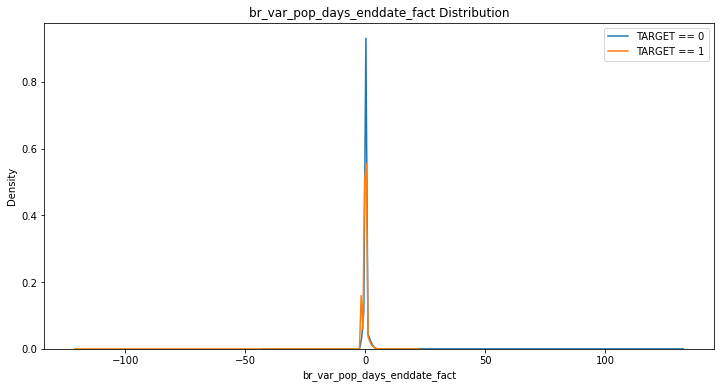

In [337]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_enddate_fact', app_train)

### br_var_samp_days_enddate_fact

In [338]:
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

,TARGET,br_var_samp_days_enddate_fact
TARGET,1.000000,-0.008178
br_var_samp_days_enddate_fact,-0.008178,1.000000


In [339]:
app_train['br_var_samp_days_enddate_fact'].isnull().sum()

215579

The correlation between br_var_samp_days_enddate_fact and the TARGET is -0.0082
Median value for loan that was not repaid = 14635.2498
Median value for loan that was repaid =     49640.2576


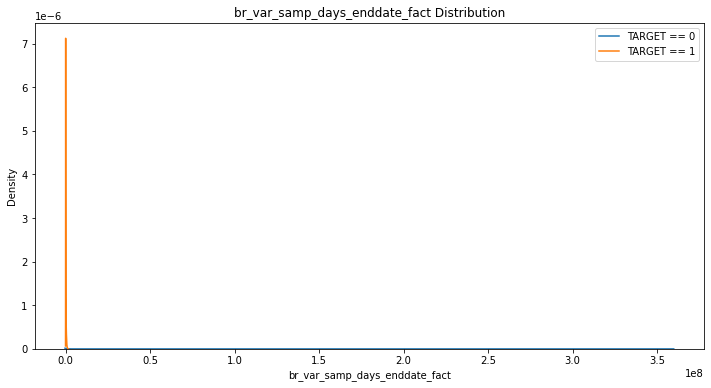

In [340]:
kde_target('br_var_samp_days_enddate_fact', app_train)

In [341]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_var_samp_days_enddate_fact
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,120134.634070
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,0.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,95357.284648
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,209882.543644
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,182420.429395


In [342]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [343]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [344]:
app_train['br_var_samp_days_enddate_fact'].isnull().sum()

0

In [345]:
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

,TARGET,br_var_samp_days_enddate_fact
TARGET,1.000000,-0.008668
br_var_samp_days_enddate_fact,-0.008668,1.000000


In [346]:
## Yao-Johnson変換
num_cols = ['br_var_samp_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

,TARGET,br_var_samp_days_enddate_fact
TARGET,1.000000,-0.049394
br_var_samp_days_enddate_fact,-0.049394,1.000000


In [347]:
## 標準化
num_cols = ['br_var_samp_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_days_enddate_fact', 'TARGET']].corr()

,br_var_samp_days_enddate_fact,TARGET
br_var_samp_days_enddate_fact,1.000000,-0.049394
TARGET,-0.049394,1.000000


The correlation between br_var_samp_days_enddate_fact and the TARGET is -0.0494
Median value for loan that was not repaid = 0.0213
Median value for loan that was repaid =     0.1869


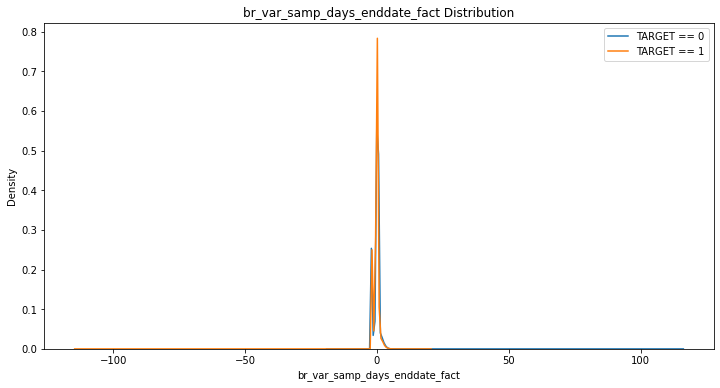

In [348]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_enddate_fact', app_train)

### br_variance_pop_days_enddate_fact

In [349]:
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

,TARGET,br_variance_pop_days_enddate_fact
TARGET,1.000000,-0.008187
br_variance_pop_days_enddate_fact,-0.008187,1.000000


In [350]:
app_train['br_variance_pop_days_enddate_fact'].isnull().sum()

215579

The correlation between br_variance_pop_days_enddate_fact and the TARGET is -0.0082
Median value for loan that was not repaid = 14174.8069
Median value for loan that was repaid =     48746.0656


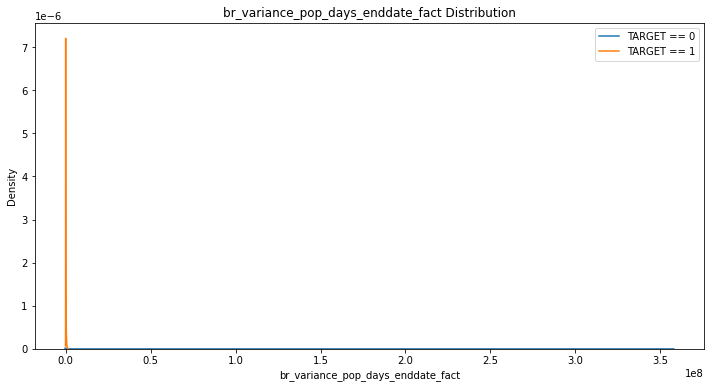

In [351]:
kde_target('br_variance_pop_days_enddate_fact', app_train)

In [352]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_variance_pop_days_enddate_fact
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,119276.529541
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,0.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,94917.850156
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,209301.151557
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,181424.360971


In [353]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [354]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [355]:
app_train['br_variance_pop_days_enddate_fact'].isnull().sum()

0

In [356]:
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

,TARGET,br_variance_pop_days_enddate_fact
TARGET,1.000000,-0.008672
br_variance_pop_days_enddate_fact,-0.008672,1.000000


In [357]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

,TARGET,br_variance_pop_days_enddate_fact
TARGET,1.000000,-0.049275
br_variance_pop_days_enddate_fact,-0.049275,1.000000


In [358]:
## 標準化
num_cols = ['br_variance_pop_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_days_enddate_fact', 'TARGET']].corr()

,br_variance_pop_days_enddate_fact,TARGET
br_variance_pop_days_enddate_fact,1.000000,-0.049275
TARGET,-0.049275,1.000000


The correlation between br_variance_pop_days_enddate_fact and the TARGET is -0.0493
Median value for loan that was not repaid = 0.0076
Median value for loan that was repaid =     0.1744


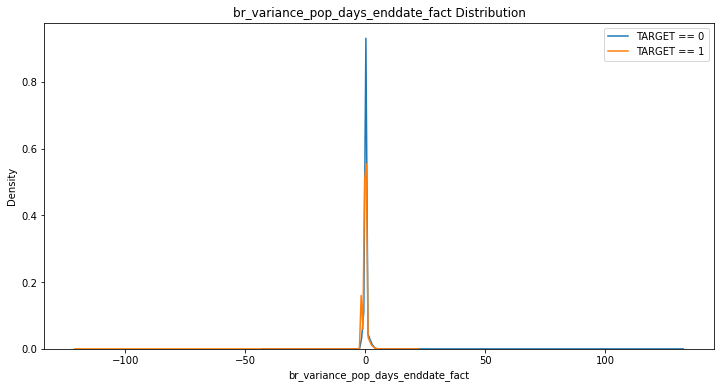

In [359]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_days_enddate_fact', app_train)

### br_min_amt_credit_max_overdue

In [360]:
app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

,TARGET,br_min_amt_credit_max_overdue
TARGET,1.000000,0.002691
br_min_amt_credit_max_overdue,0.002691,1.000000


In [361]:
app_train['br_min_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_min_amt_credit_max_overdue and the TARGET is 0.0027
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


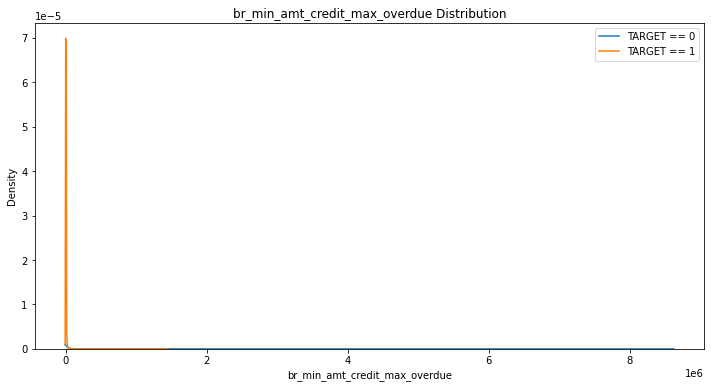

In [362]:
kde_target('br_min_amt_credit_max_overdue', app_train)

In [363]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [364]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [365]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [366]:
#app_train['br_min_amt_credit_max_overdue'].isnull().sum()

In [367]:
#app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

In [368]:
#num_cols = ['br_min_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
#app_train['br_min_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

#app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

In [369]:
## 標準化
#num_cols = ['br_min_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_credit_max_overdue', 'TARGET']].corr()

In [370]:
#kde_target('br_min_amt_credit_max_overdue', app_train)

In [371]:
columns = ['br_min_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_amt_credit_max_overdue

In [372]:
app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

,TARGET,br_max_amt_credit_max_overdue
TARGET,1.000000,0.000545
br_max_amt_credit_max_overdue,0.000545,1.000000


In [373]:
app_train['br_max_amt_credit_max_overdue'].isnull().sum()

215579

In [374]:
#kde_target('br_max_amt_credit_max_overdue', app_train)

In [375]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [376]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [377]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [378]:
#app_train['br_max_amt_credit_max_overdue'].isnull().sum()

In [379]:
#app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

In [380]:
#num_cols = ['br_max_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
#app_train['br_max_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

#app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

In [381]:
## 標準化
#num_cols = ['br_max_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_amt_credit_max_overdue', 'TARGET']].corr()

In [382]:
#kde_target('br_max_amt_credit_max_overdue', app_train)

In [383]:
columns = ['br_max_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_amt_credit_max_overdue

In [384]:
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

,TARGET,br_sum_amt_credit_max_overdue
TARGET,1.000000,-0.000177
br_sum_amt_credit_max_overdue,-0.000177,1.000000


In [385]:
app_train['br_sum_amt_credit_max_overdue'].isnull().sum()

215579

In [386]:
#kde_target('br_sum_amt_credit_max_overdue', app_train)

In [387]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [388]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [389]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()


In [390]:
#app_train['br_sum_amt_credit_max_overdue'].isnull().sum()

In [391]:
#app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

In [392]:
#num_cols = ['br_sum_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
#app_train['br_sum_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

#app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

In [393]:
## 標準化
#num_cols = ['br_sum_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_amt_credit_max_overdue', 'TARGET']].corr()

In [394]:
#kde_target('br_sum_amt_credit_max_overdue', app_train)

In [395]:
columns = ['br_sum_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_amt_credit_max_overdue

In [396]:
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

,TARGET,br_avg_amt_credit_max_overdue
TARGET,1.000000,-0.000019
br_avg_amt_credit_max_overdue,-0.000019,1.000000


In [397]:
app_train['br_avg_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_avg_amt_credit_max_overdue and the TARGET is -0.0000
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


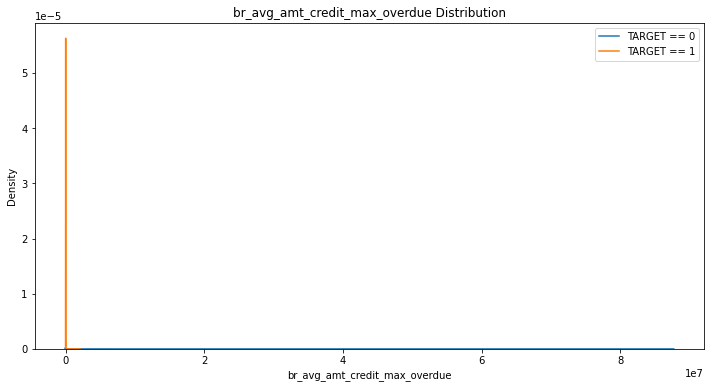

In [398]:
kde_target('br_avg_amt_credit_max_overdue', app_train)

In [399]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_amt_credit_max_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_avg_amt_credit_max_overdue
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,0.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,0.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,19305.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,0.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,3072.974928


In [400]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [401]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [402]:
app_train['br_avg_amt_credit_max_overdue'].isnull().sum()

0

In [403]:
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

,TARGET,br_avg_amt_credit_max_overdue
TARGET,1.000000,-0.000118
br_avg_amt_credit_max_overdue,-0.000118,1.000000


In [404]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

,TARGET,br_avg_amt_credit_max_overdue
TARGET,1.000000,0.009894
br_avg_amt_credit_max_overdue,0.009894,1.000000


In [405]:
## 標準化
num_cols = ['br_avg_amt_credit_max_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_amt_credit_max_overdue', 'TARGET']].corr()

,br_avg_amt_credit_max_overdue,TARGET
br_avg_amt_credit_max_overdue,1.000000,0.009894
TARGET,0.009894,1.000000


The correlation between br_avg_amt_credit_max_overdue and the TARGET is 0.0099
Median value for loan that was not repaid = 0.3705
Median value for loan that was repaid =     0.3557


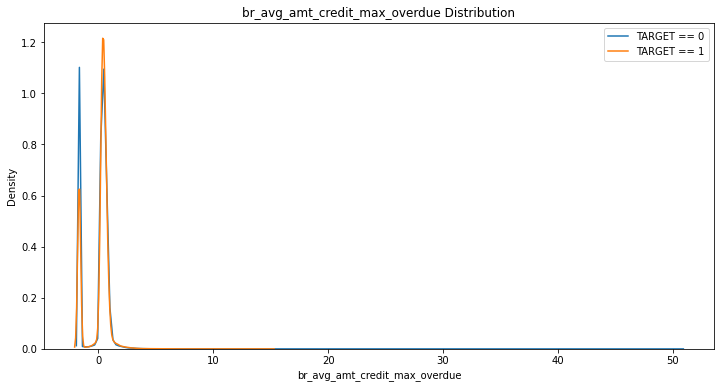

In [406]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_max_overdue', app_train)

### br_cnt_amt_credit_max_overdue

In [407]:
app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

,TARGET,br_cnt_amt_credit_max_overdue
TARGET,1.000000,-0.019445
br_cnt_amt_credit_max_overdue,-0.019445,1.000000


In [408]:
app_train['br_cnt_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_cnt_amt_credit_max_overdue and the TARGET is -0.0194
Median value for loan that was not repaid = 16.0000
Median value for loan that was repaid =     19.0000


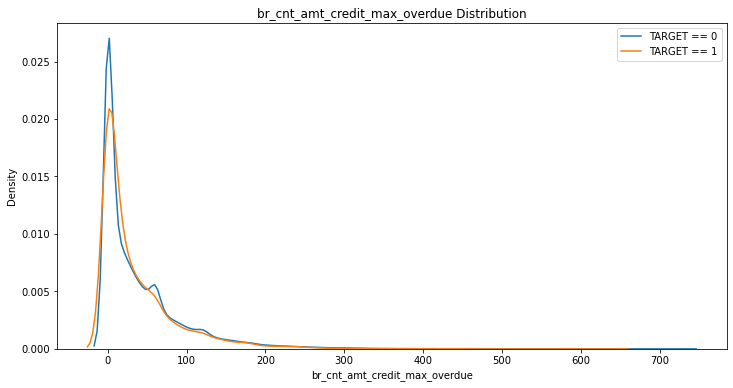

In [409]:
kde_target('br_cnt_amt_credit_max_overdue', app_train)

In [410]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_cnt_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [411]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [412]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [413]:
#app_train['br_cnt_amt_credit_max_overdue'].isnull().sum()

In [414]:
#app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

In [415]:
## Yao-Johnson変換
#num_cols = ['br_cnt_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_cnt_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_cnt_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

In [416]:
## 標準化
#num_cols = ['br_cnt_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_cnt_amt_credit_max_overdue', 'TARGET']].corr()

In [417]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_cnt_amt_credit_max_overdue', app_train)

In [418]:
columns = ['br_cnt_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_amt_credit_max_overdue

In [419]:
app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

,TARGET,br_stddev_amt_credit_max_overdue
TARGET,1.000000,0.000837
br_stddev_amt_credit_max_overdue,0.000837,1.000000


In [420]:
app_train['br_stddev_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_stddev_amt_credit_max_overdue and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


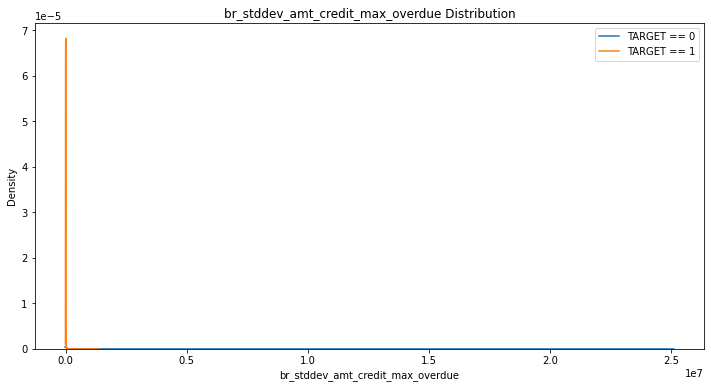

In [421]:
kde_target('br_stddev_amt_credit_max_overdue', app_train)

In [422]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [423]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [424]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [425]:
#app_train['br_stddev_amt_credit_max_overdue'].isnull().sum()

In [426]:
#app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

In [427]:
## Yao-Johnson変換
#num_cols = ['br_stddev_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

In [428]:
## 標準化
#num_cols = ['br_stddev_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_amt_credit_max_overdue', 'TARGET']].corr()

In [429]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_amt_credit_max_overdue', app_train)

In [430]:
columns = ['br_stddev_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_amt_credit_max_overdue

In [431]:
app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

,TARGET,br_stddev_pop_amt_credit_max_overdue
TARGET,1.000000,0.000837
br_stddev_pop_amt_credit_max_overdue,0.000837,1.000000


In [432]:
app_train['br_stddev_pop_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_stddev_pop_amt_credit_max_overdue and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


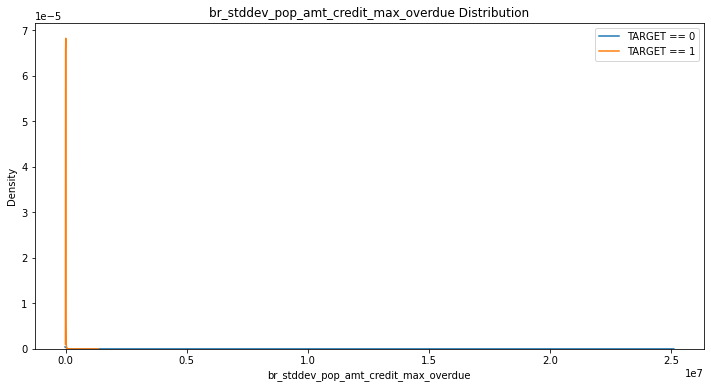

In [433]:
kde_target('br_stddev_pop_amt_credit_max_overdue', app_train)

In [434]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [435]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [436]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [437]:
#app_train['br_stddev_pop_amt_credit_max_overdue'].isnull().sum()

In [438]:
#app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

In [439]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [440]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

In [441]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_credit_max_overdue', app_train)

In [442]:
columns = ['br_stddev_pop_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_credit_max_overdue

In [443]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

,TARGET,br_var_pop_amt_credit_max_overdue
TARGET,1.000000,-0.000962
br_var_pop_amt_credit_max_overdue,-0.000962,1.000000


In [444]:
app_train['br_var_pop_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_var_pop_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


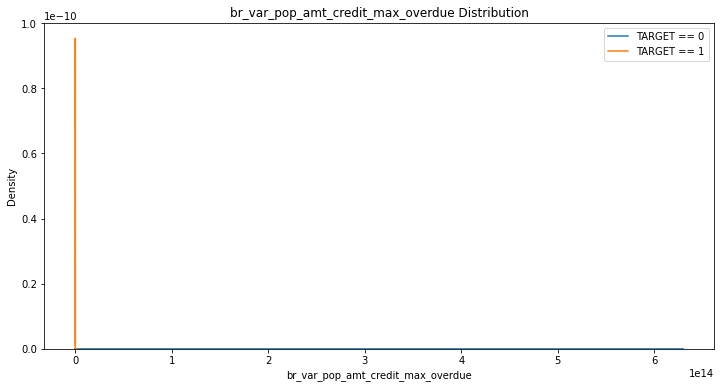

In [445]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_max_overdue', app_train)

In [446]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [447]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [448]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [449]:
#app_train['br_var_pop_amt_credit_max_overdue'].isnull().sum()

In [450]:
#app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

In [451]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

In [452]:
## 標準化
#num_cols = ['br_var_pop_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_credit_max_overdue', 'TARGET']].corr()

In [453]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_credit_max_overdue', app_train)

In [454]:
columns = ['br_var_pop_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_credit_max_overdue

In [455]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

,TARGET,br_var_samp_amt_credit_max_overdue
TARGET,1.000000,-0.000962
br_var_samp_amt_credit_max_overdue,-0.000962,1.000000


In [456]:
app_train['br_var_samp_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_var_samp_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


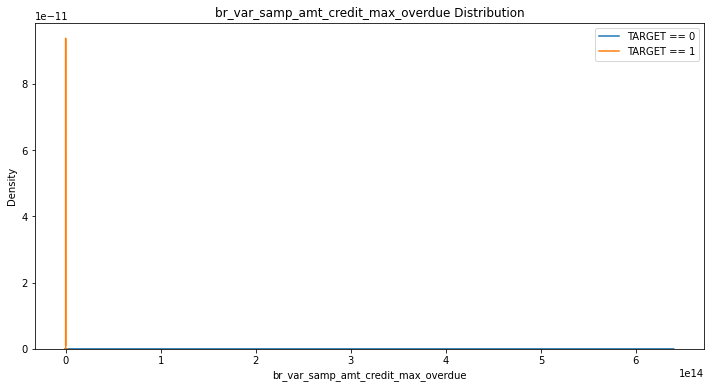

In [457]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_max_overdue', app_train)

In [458]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [459]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [460]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [461]:
#app_train['br_var_samp_amt_credit_max_overdue'].isnull().sum()

In [462]:
#app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

In [463]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

In [464]:
## 標準化
#num_cols = ['br_var_samp_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_credit_max_overdue', 'TARGET']].corr()

In [465]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_credit_max_overdue', app_train)

In [466]:
columns = ['br_var_samp_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_credit_max_overdue

In [467]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

,TARGET,br_variance_pop_amt_credit_max_overdue
TARGET,1.000000,-0.000962
br_variance_pop_amt_credit_max_overdue,-0.000962,1.000000


In [468]:
app_train['br_variance_pop_amt_credit_max_overdue'].isnull().sum()

215579

The correlation between br_variance_pop_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


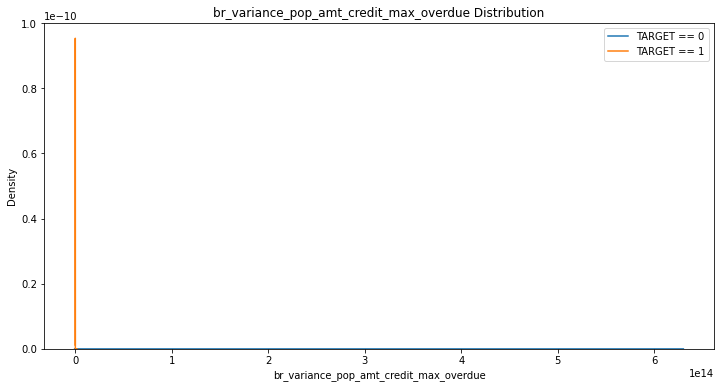

In [469]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_max_overdue', app_train)

In [470]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_credit_day_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [471]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [472]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [473]:
#app_train['br_variance_pop_amt_credit_max_overdue'].isnull().sum()

In [474]:
#app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

In [475]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

In [476]:
## 標準化
#num_cols = ['br_variance_pop_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_amt_credit_max_overdue', 'TARGET']].corr()

In [477]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_amt_credit_max_overdue', app_train)

In [478]:
columns = ['br_variance_pop_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_min_cnt_credit_prolong

In [479]:
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

,TARGET,br_min_cnt_credit_prolong
TARGET,1.000000,0.005553
br_min_cnt_credit_prolong,0.005553,1.000000


In [480]:
app_train['br_min_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_min_cnt_credit_prolong and the TARGET is 0.0056
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


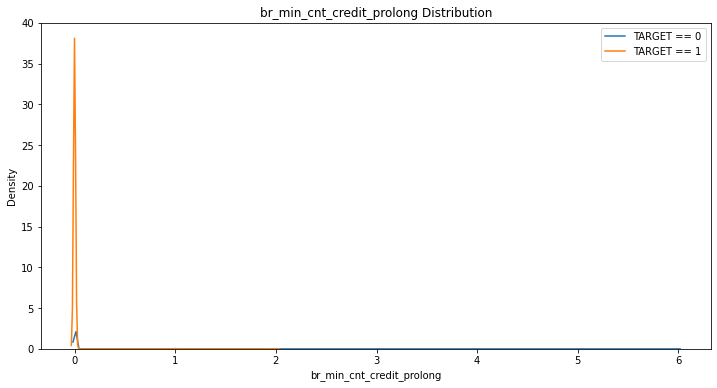

In [481]:
kde_target('br_min_cnt_credit_prolong', app_train)

In [482]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_min_cnt_credit_prolong
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,0.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,0.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,0.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,0.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,0.000589


In [483]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [484]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [485]:
app_train['br_min_cnt_credit_prolong'].isnull().sum()

0

In [486]:
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

,TARGET,br_min_cnt_credit_prolong
TARGET,1.000000,0.005063
br_min_cnt_credit_prolong,0.005063,1.000000


In [487]:
## Yao-Johnson変換
num_cols = ['br_min_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_min_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

,TARGET,br_min_cnt_credit_prolong
TARGET,1.000000,0.031651
br_min_cnt_credit_prolong,0.031651,1.000000


In [488]:
## 標準化
num_cols = ['br_min_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_min_cnt_credit_prolong', 'TARGET']].corr()

,br_min_cnt_credit_prolong,TARGET
br_min_cnt_credit_prolong,1.000000,0.031651
TARGET,0.031651,1.000000


The correlation between br_min_cnt_credit_prolong and the TARGET is 0.0317
Median value for loan that was not repaid = 0.0814
Median value for loan that was repaid =     -0.0955


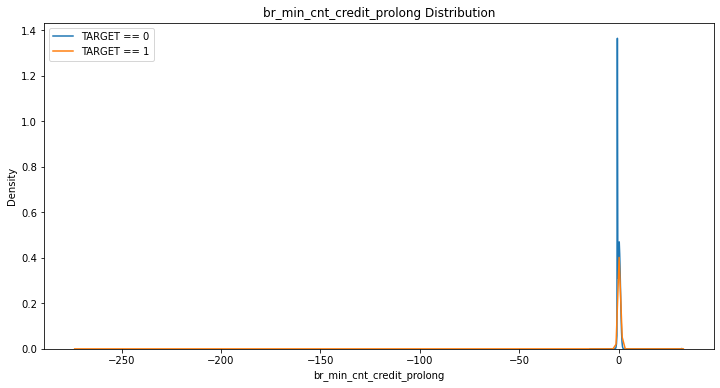

In [489]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_cnt_credit_prolong', app_train)

### br_max_cnt_credit_prolong

In [490]:
## 目的変数との相関
app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

,TARGET,br_max_cnt_credit_prolong
TARGET,1.000000,0.007141
br_max_cnt_credit_prolong,0.007141,1.000000


In [491]:
app_train['br_max_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_max_cnt_credit_prolong and the TARGET is 0.0071
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


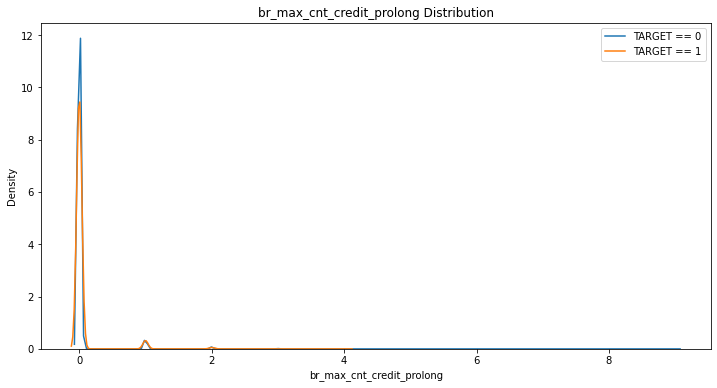

In [492]:
## 特徴量の分布
kde_target('br_max_cnt_credit_prolong', app_train)

In [493]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_cnt_credit_prolong')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [494]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [495]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [496]:
#app_train['br_max_cnt_credit_prolong'].isnull().sum()

In [497]:
#app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

In [498]:
## Yao-Johnson変換
#num_cols = ['br_max_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
#app_test['br_max_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

In [499]:
## 標準化
#num_cols = ['br_max_cnt_credit_prolong']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_cnt_credit_prolong', 'TARGET']].corr()

In [500]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_cnt_credit_prolong', app_train)

In [501]:
columns = ['br_max_cnt_credit_prolong']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_cnt_credit_prolong

In [502]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

,TARGET,br_sum_cnt_credit_prolong
TARGET,1.000000,-0.002808
br_sum_cnt_credit_prolong,-0.002808,1.000000


In [503]:
app_train['br_sum_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_sum_cnt_credit_prolong and the TARGET is -0.0028
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


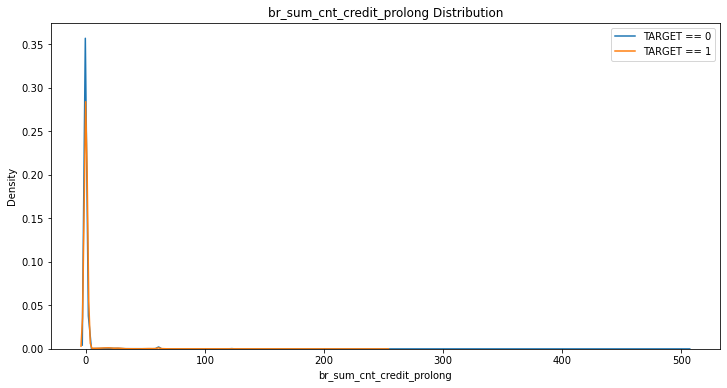

In [504]:
## 特徴量の分布
kde_target('br_sum_cnt_credit_prolong', app_train)

In [505]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_cnt_credit_prolong')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [506]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [507]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [508]:
#app_train['br_sum_cnt_credit_prolong'].isnull().sum()

In [509]:
#app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

In [510]:
## Yao-Johnson変換
#num_cols = ['br_sum_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
#app_test['br_sum_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

In [511]:
## 標準化
#num_cols = ['br_sum_cnt_credit_prolong']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_cnt_credit_prolong', 'TARGET']].corr()

In [512]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_cnt_credit_prolong', app_train)

In [513]:
columns = ['br_sum_cnt_credit_prolong']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_cnt_credit_prolong

In [514]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

,TARGET,br_avg_cnt_credit_prolong
TARGET,1.000000,0.007663
br_avg_cnt_credit_prolong,0.007663,1.000000


In [515]:
app_train['br_avg_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_avg_cnt_credit_prolong and the TARGET is 0.0077
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


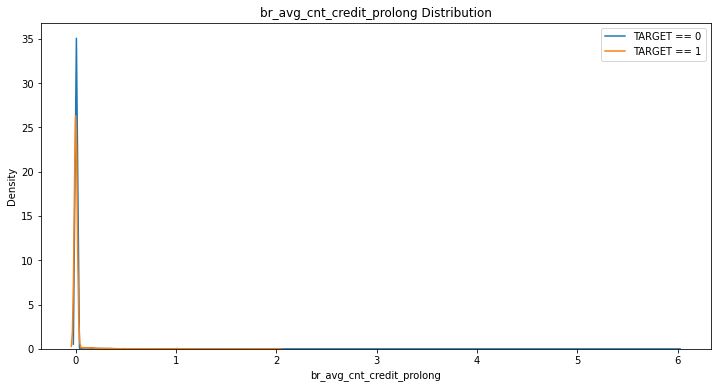

In [516]:
## 特徴量の分布
kde_target('br_avg_cnt_credit_prolong', app_train)

In [517]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_avg_cnt_credit_prolong
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,0.00000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,0.00000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,0.00000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,0.00000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,0.00229


In [518]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [519]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [520]:
app_train['br_avg_cnt_credit_prolong'].isnull().sum()

0

In [521]:
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

,TARGET,br_avg_cnt_credit_prolong
TARGET,1.000000,0.007103
br_avg_cnt_credit_prolong,0.007103,1.000000


In [522]:
## Yao-Johnson変換
num_cols = ['br_avg_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_avg_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

,TARGET,br_avg_cnt_credit_prolong
TARGET,1.000000,0.021714
br_avg_cnt_credit_prolong,0.021714,1.000000


In [523]:
## 標準化
num_cols = ['br_avg_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_cnt_credit_prolong', 'TARGET']].corr()

,br_avg_cnt_credit_prolong,TARGET
br_avg_cnt_credit_prolong,1.000000,0.021714
TARGET,0.021714,1.000000


The correlation between br_avg_cnt_credit_prolong and the TARGET is 0.0217
Median value for loan that was not repaid = 0.4400
Median value for loan that was repaid =     0.2887


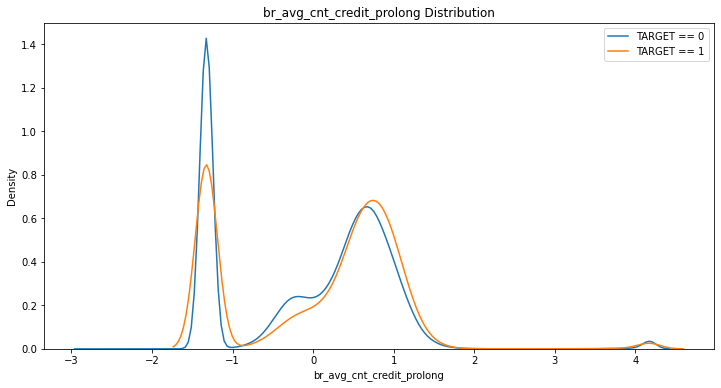

In [524]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_cnt_credit_prolong', app_train)

### br_cnt_cnt_credit_prolong

In [525]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_cnt_credit_prolong']].corr()

,TARGET,br_cnt_cnt_credit_prolong
TARGET,1.000000,-0.040412
br_cnt_cnt_credit_prolong,-0.040412,1.000000


In [526]:
app_train['br_cnt_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_cnt_cnt_credit_prolong and the TARGET is -0.0404
Median value for loan that was not repaid = 80.0000
Median value for loan that was repaid =     102.0000


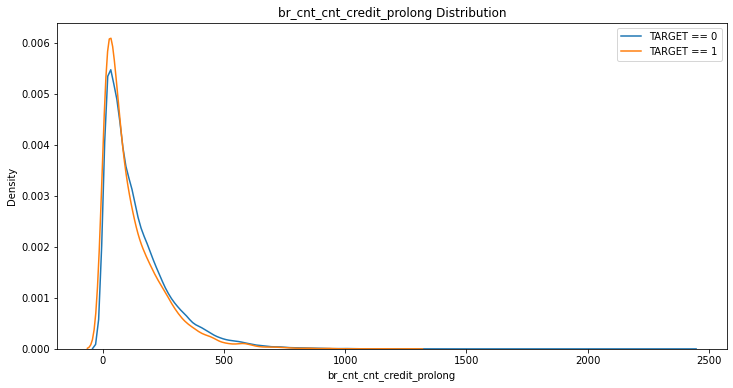

In [527]:
## 特徴量の分布
kde_target('br_cnt_cnt_credit_prolong', app_train)

In [528]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_cnt_cnt_credit_prolong
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,172.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,21.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,217.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,536.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,192.700818


In [529]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [530]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [531]:
app_train['br_cnt_cnt_credit_prolong'].isnull().sum()

0

In [532]:
app_train[['TARGET', 'br_cnt_cnt_credit_prolong']].corr()

,TARGET,br_cnt_cnt_credit_prolong
TARGET,1.000000,-0.048315
br_cnt_cnt_credit_prolong,-0.048315,1.000000


In [533]:
## Yao-Johnson変換
num_cols = ['br_cnt_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_cnt_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_cnt_credit_prolong']].corr()

,TARGET,br_cnt_cnt_credit_prolong
TARGET,1.000000,-0.061147
br_cnt_cnt_credit_prolong,-0.061147,1.000000


In [534]:
## 標準化
num_cols = ['br_cnt_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_cnt_credit_prolong', 'TARGET']].corr()

,br_cnt_cnt_credit_prolong,TARGET
br_cnt_cnt_credit_prolong,1.000000,-0.061147
TARGET,-0.061147,1.000000


The correlation between br_cnt_cnt_credit_prolong and the TARGET is -0.0611
Median value for loan that was not repaid = -0.1318
Median value for loan that was repaid =     0.0741


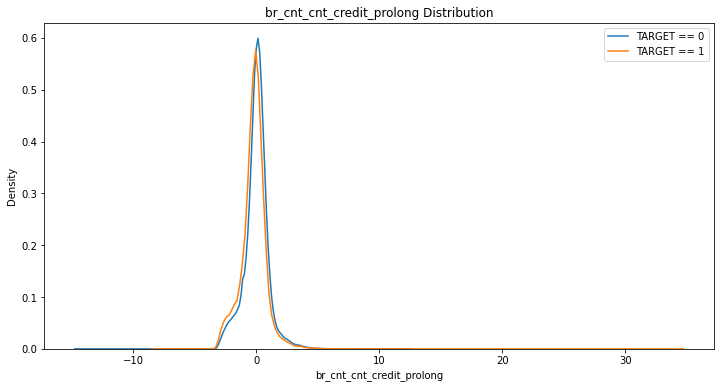

In [535]:
## 特徴量の分布
kde_target('br_cnt_cnt_credit_prolong', app_train)

### br_stddev_cnt_credit_prolong

In [536]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

,TARGET,br_stddev_cnt_credit_prolong
TARGET,1.000000,0.005682
br_stddev_cnt_credit_prolong,0.005682,1.000000


In [537]:
app_train['br_stddev_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_stddev_cnt_credit_prolong and the TARGET is 0.0057
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


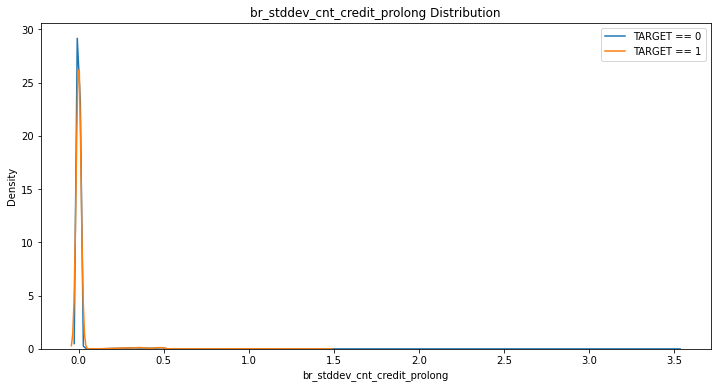

In [538]:
## 特徴量の分布
kde_target('br_stddev_cnt_credit_prolong', app_train)

In [539]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_cnt_credit_prolong')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [540]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [541]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [542]:
#app_train['br_stddev_cnt_credit_prolong'].isnull().sum()

In [543]:
#app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

In [544]:
## Yao-Johnson変換
#num_cols = ['br_stddev_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

In [545]:
## 標準化
#num_cols = ['br_stddev_cnt_credit_prolong']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_cnt_credit_prolong', 'TARGET']].corr()

In [546]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_cnt_credit_prolong', app_train)

In [547]:
columns = ['br_stddev_cnt_credit_prolong']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_cnt_credit_prolong

In [548]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

,TARGET,br_stddev_pop_cnt_credit_prolong
TARGET,1.000000,0.005682
br_stddev_pop_cnt_credit_prolong,0.005682,1.000000


In [549]:
app_train['br_stddev_pop_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_stddev_pop_cnt_credit_prolong and the TARGET is 0.0057
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


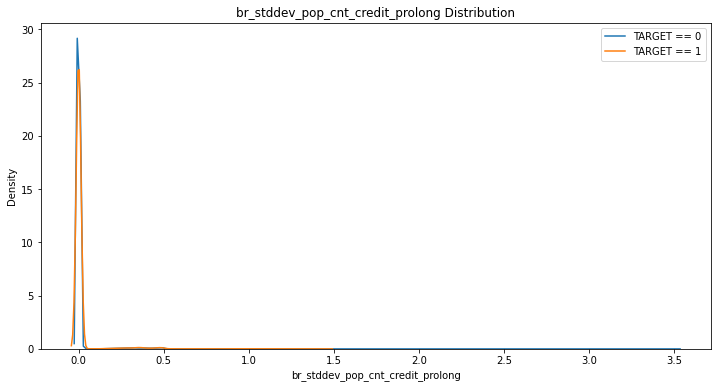

In [550]:
## 特徴量の分布
kde_target('br_stddev_pop_cnt_credit_prolong', app_train)

In [551]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_stddev_pop_cnt_credit_prolong
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,0.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,0.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,0.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,0.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,0.003026


In [552]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [553]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [554]:
app_train['br_stddev_pop_cnt_credit_prolong'].isnull().sum()

0

In [555]:
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

,TARGET,br_stddev_pop_cnt_credit_prolong
TARGET,1.000000,0.004294
br_stddev_pop_cnt_credit_prolong,0.004294,1.000000


In [556]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

,TARGET,br_stddev_pop_cnt_credit_prolong
TARGET,1.000000,0.005856
br_stddev_pop_cnt_credit_prolong,0.005856,1.000000


In [557]:
## 標準化
num_cols = ['br_stddev_pop_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_cnt_credit_prolong', 'TARGET']].corr()

,br_stddev_pop_cnt_credit_prolong,TARGET
br_stddev_pop_cnt_credit_prolong,1.000000,0.005856
TARGET,0.005856,1.000000


The correlation between br_stddev_pop_cnt_credit_prolong and the TARGET is 0.0059
Median value for loan that was not repaid = 0.3860
Median value for loan that was repaid =     0.3360


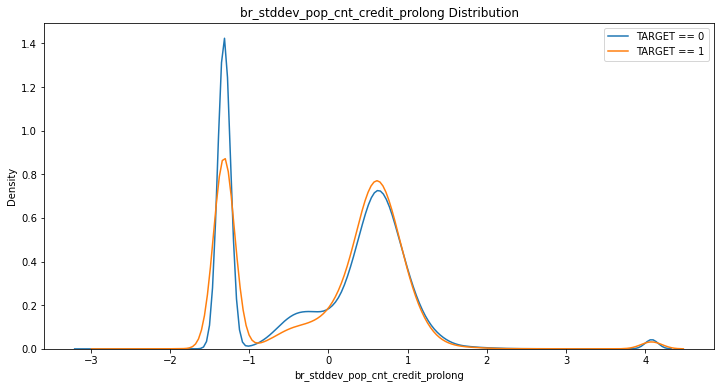

In [558]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_cnt_credit_prolong', app_train)

### br_var_pop_cnt_credit_prolong

In [559]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

,TARGET,br_var_pop_cnt_credit_prolong
TARGET,1.000000,0.000646
br_var_pop_cnt_credit_prolong,0.000646,1.000000


In [560]:
app_train['br_var_pop_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_var_pop_cnt_credit_prolong and the TARGET is 0.0006
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


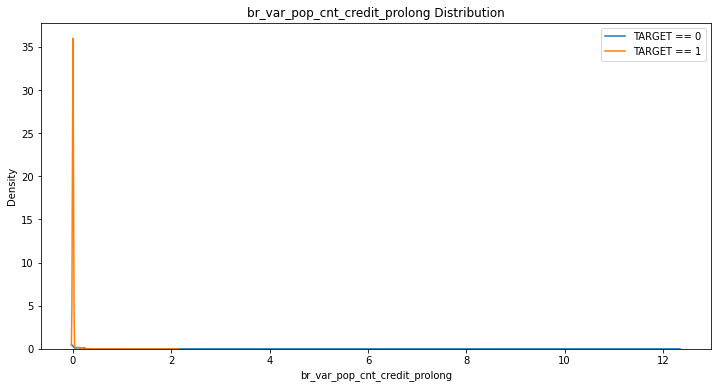

In [561]:
## 特徴量の分布
kde_target('br_var_pop_cnt_credit_prolong', app_train)

In [562]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT,br_var_pop_cnt_credit_prolong
0,100001.0,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,1.2640,-118800.0,52.715068,0.000000
1,100005.0,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,1.2376,-42768.0,49.490411,0.000000
2,100013.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,1.0528,-33264.0,54.898630,0.000000
3,100028.0,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,1.0000,0.0,38.290411,0.000000
4,100038.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,1.0000,0.0,35.726027,0.001408


In [563]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [564]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,credit_annuity_ratio,DAYS_EMPLOYED_ANOM,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100001,0.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.0,...,0.0,0.000000,0.000000,0.036147,0.121044,19.775662,False,1.2640,-118800.0,52.715068
1,100005,0.0,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,...,0.0,0.000000,3.000000,0.077973,0.247398,74.467617,False,1.2376,-42768.0,49.490411
2,100013,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,0.0,...,0.0,0.000000,4.000000,0.105202,0.222477,1.934735,False,1.0528,-33264.0,54.898630
3,100028,0.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.0,...,0.0,0.000000,3.000000,0.031123,0.133515,6.378867,False,1.0000,0.0,38.290411
4,100038,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.0,...,0.0,0.010242,1.748333,0.051266,0.168021,15.997755,False,1.0000,0.0,35.726027


In [565]:
app_train['br_var_pop_cnt_credit_prolong'].isnull().sum()

0

In [566]:
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

,TARGET,br_var_pop_cnt_credit_prolong
TARGET,1.000000,0.000998
br_var_pop_cnt_credit_prolong,0.000998,1.000000


In [567]:
## Yao-Johnson変換
num_cols = ['br_var_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

,TARGET,br_var_pop_cnt_credit_prolong
TARGET,1.000000,0.005925
br_var_pop_cnt_credit_prolong,0.005925,1.000000


In [568]:
## 標準化
num_cols = ['br_var_pop_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_cnt_credit_prolong', 'TARGET']].corr()

,br_var_pop_cnt_credit_prolong,TARGET
br_var_pop_cnt_credit_prolong,1.000000,0.005925
TARGET,0.005925,1.000000


The correlation between br_var_pop_cnt_credit_prolong and the TARGET is 0.0059
Median value for loan that was not repaid = 0.3962
Median value for loan that was repaid =     0.3592


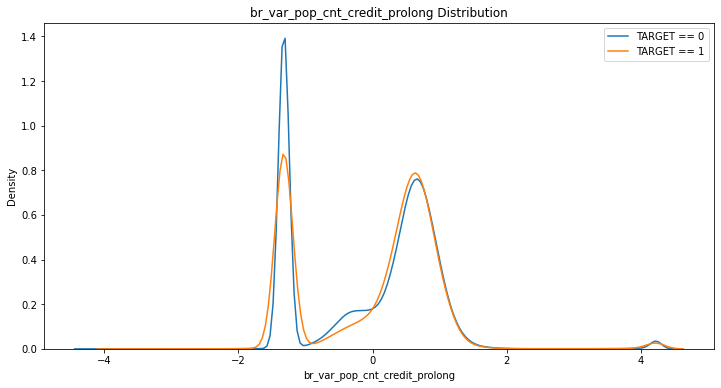

In [569]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_cnt_credit_prolong', app_train)

### br_var_samp_cnt_credit_prolong

In [570]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

,TARGET,br_var_samp_cnt_credit_prolong
TARGET,1.000000,0.000765
br_var_samp_cnt_credit_prolong,0.000765,1.000000


In [571]:
app_train['br_var_samp_cnt_credit_prolong'].isnull().sum()

215579

The correlation between br_var_samp_cnt_credit_prolong and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


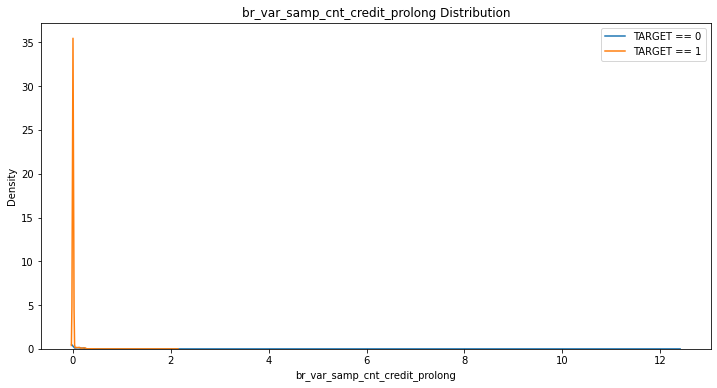

In [572]:
## 特徴量の分布
kde_target('br_var_samp_cnt_credit_prolong', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_var_samp_cnt_credit_prolong'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_var_samp_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

In [ ]:
## 標準化
num_cols = ['br_var_samp_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_cnt_credit_prolong', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_cnt_credit_prolong', app_train)

### br_variance_pop_cnt_credit_prolong

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

In [ ]:
app_train['br_variance_pop_cnt_credit_prolong'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_variance_pop_cnt_credit_prolong', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_variance_pop_cnt_credit_prolong'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

In [ ]:
## 標準化
num_cols = ['br_variance_pop_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_cnt_credit_prolong', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_cnt_credit_prolong', app_train)

### br_min_amt_credit_sum

In [ ]:
app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

In [ ]:
app_train['br_min_amt_credit_sum'].isnull().sum()

In [ ]:
kde_target('br_min_amt_credit_sum', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()


In [ ]:
#app_train['br_min_amt_credit_sum'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_min_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

In [ ]:
## 標準化
#num_cols = ['br_min_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_credit_sum', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_min_amt_credit_sum', app_train)

In [ ]:
columns = ['br_min_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_amt_credit_sum

In [ ]:
app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

In [ ]:
app_train['br_max_amt_credit_sum'].isnull().sum()

In [ ]:
kde_target('br_max_amt_credit_sum', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_max_amt_credit_sum'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_max_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

In [ ]:
## 標準化
#num_cols = ['br_max_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_amt_credit_sum', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_amt_credit_sum', app_train)

In [ ]:
columns = ['br_max_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_amt_credit_sum

In [ ]:
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

In [ ]:
app_train['br_sum_amt_credit_sum'].isnull().sum()

In [ ]:
kde_target('br_sum_amt_credit_sum', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_sum_amt_credit_sum'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

In [ ]:
## 標準化
num_cols = ['br_sum_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_amt_credit_sum', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum', app_train)

### br_avg_amt_credit_sum

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

In [ ]:
app_train['br_avg_amt_credit_sum'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_avg_amt_credit_sum'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

In [ ]:
## 標準化
num_cols = ['br_avg_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_amt_credit_sum', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum', app_train)

### br_cnt_amt_credit_sum

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

In [ ]:
app_train['br_cnt_amt_credit_sum'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_cnt_amt_credit_sum'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

In [ ]:
## 標準化
num_cols = ['br_cnt_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_credit_sum', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum', app_train)

### br_stddev_amt_credit_sum

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum']].corr()

In [ ]:
app_train['br_stddev_amt_credit_sum'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_stddev_amt_credit_sum'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_stddev_amt_credit_sum']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum']].corr()

In [ ]:
## 標準化
num_cols = ['br_stddev_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_amt_credit_sum', 'TARGET']].corr()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum', app_train)

In [ ]:
#######################################

In [ ]:
#######################################

In [ ]:
#######################################

In [ ]:
#######################################

In [ ]:
#######################################

In [ ]:
#######################################

### br_stddev_pop_amt_credit_sum

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum']].corr()

In [ ]:
app_train['br_stddev_pop_amt_credit_sum'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_stddev_pop_amt_credit_sum'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum']].corr()

In [ ]:
## 標準化
#num_cols = ['br_stddev_pop_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_pop_amt_credit_sum', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_credit_sum', app_train)

In [ ]:
columns = ['br_stddev_pop_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_credit_sum

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

In [ ]:
app_train['br_var_pop_amt_credit_sum'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()


In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()


In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_var_pop_amt_credit_sum'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

In [ ]:
## 標準化
#num_cols = ['br_var_pop_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_credit_sum', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_credit_sum', app_train)

In [ ]:
columns = ['br_var_pop_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_credit_sum

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

In [ ]:
app_train['br_var_samp_amt_credit_sum'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_var_samp_amt_credit_sum'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

In [ ]:
## 標準化
#num_cols = ['br_var_samp_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_credit_sum', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_credit_sum', app_train)

In [ ]:
columns = ['br_var_samp_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_credit_sum

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

In [ ]:
app_train['br_variance_pop_amt_credit_sum'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_variance_pop_amt_credit_sum'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [ ]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

In [ ]:
## 標準化
num_cols = ['br_variance_pop_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_amt_credit_sum', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

### br_min_amt_credit_sum_debt

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

In [ ]:
app_train['br_min_amt_credit_sum_debt'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_debt', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
app_train['br_min_amt_credit_sum_debt'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_min_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

In [ ]:
## 標準化
#num_cols = ['br_min_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_credit_sum_debt', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_min_amt_credit_sum_debt', app_train)

In [ ]:
columns = ['br_min_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)


### br_max_amt_credit_sum_debt

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

In [ ]:
app_train['br_max_amt_credit_sum_debt'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_debt', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_max_amt_credit_sum_debt'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_max_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

In [ ]:
## 標準化
#num_cols = ['br_max_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_amt_credit_sum_debt', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_amt_credit_sum_debt', app_train)

In [ ]:
columns = ['br_max_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_amt_credit_sum_debt

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

In [ ]:
app_train['br_sum_amt_credit_sum_debt'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_debt', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_sum_amt_credit_sum_debt'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_sum_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

In [ ]:
## 標準化
#num_cols = ['br_sum_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_amt_credit_sum_debt', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_amt_credit_sum_debt', app_train)

In [ ]:
app_train.drop(['br_sum_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_sum_amt_credit_sum_debt'], axis=1, inplace=True)

### br_avg_amt_credit_sum_debt

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

In [ ]:
app_train['br_avg_amt_credit_sum_debt'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_debt', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_avg_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_avg_amt_credit_sum_debt'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_avg_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_avg_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

In [ ]:
## 標準化
#num_cols = ['br_avg_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_avg_amt_credit_sum_debt', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_amt_credit_sum_debt', app_train)

In [ ]:
app_train.drop(['br_avg_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_avg_amt_credit_sum_debt'], axis=1, inplace=True)

### br_cnt_amt_credit_sum_debt

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

In [ ]:
app_train['br_cnt_amt_credit_sum_debt'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_debt', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_credit_sum_debt')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_cnt_amt_credit_sum_debt'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

In [ ]:
## 標準化
num_cols = ['br_cnt_amt_credit_sum_debt']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_credit_sum_debt', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_debt', app_train)

### br_stddev_amt_credit_sum_debt

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

In [ ]:
app_train['br_stddev_amt_credit_sum_debt'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_debt', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()


In [ ]:
#app_train['br_stddev_amt_credit_sum_debt'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_stddev_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

In [ ]:
## 標準化
#num_cols = ['br_stddev_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_amt_credit_sum_debt', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_amt_credit_sum_debt', app_train)

In [ ]:
columns = ['br_stddev_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_amt_credit_sum_debt

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_debt']].corr()

In [ ]:
app_train['br_stddev_pop_amt_credit_sum_debt'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_debt', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_stddev_pop_amt_credit_sum_debt'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_debt']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_debt']].corr()

In [ ]:
## 標準化
#num_cols = ['br_stddev_pop_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_pop_amt_credit_sum_debt', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_credit_sum_debt', app_train)

In [ ]:
columns = ['br_stddev_pop_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_credit_sum_debt

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

In [ ]:
app_train['br_var_pop_amt_credit_sum_debt'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_debt', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_var_pop_amt_credit_sum_debt'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

In [ ]:
## 標準化
#num_cols = ['br_var_pop_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_credit_sum_debt', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_credit_sum_debt', app_train)

In [ ]:
columns = ['br_var_pop_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_credit_sum_debt

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

In [ ]:
app_train['br_var_samp_amt_credit_sum_debt'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_debt', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_var_samp_amt_credit_sum_debt'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

In [ ]:
## 標準化
#num_cols = ['br_var_samp_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_credit_sum_debt', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_credit_sum_debt', app_train)

In [ ]:
columns = ['br_var_samp_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_credit_sum_debt

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

In [ ]:
app_train['br_variance_pop_amt_credit_sum_debt'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_debt', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_variance_pop_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_variance_pop_amt_credit_sum_debt'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

In [ ]:
## 標準化
#num_cols = ['br_variance_pop_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_amt_credit_sum_debt', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_amt_credit_sum_debt', app_train)

In [ ]:
columns = ['br_variance_pop_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_min_amt_credit_sum_limit

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

In [ ]:
app_train['br_min_amt_credit_sum_limit'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_limit', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_credit_sum_limit')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_min_amt_credit_sum_limit'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_min_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

In [ ]:
## 標準化
#num_cols = ['br_min_amt_credit_sum_limit']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_credit_sum_limit', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_min_amt_credit_sum_limit', app_train)

In [ ]:
columns = ['br_min_amt_credit_sum_limit']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_amt_credit_sum_limit

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

In [ ]:
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

In [ ]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_limit', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_max_amt_credit_sum_limit'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

In [ ]:
## 標準化
num_cols = ['br_max_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_amt_credit_sum_limit', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum_limit', app_train)

### br_sum_amt_credit_sum_limit

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

In [ ]:
app_train['br_sum_amt_credit_sum_limit'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_limit', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()


In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_sum_amt_credit_sum_limit'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

In [ ]:
## 標準化
num_cols = ['br_sum_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_amt_credit_sum_limit', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum_limit', app_train)

### br_avg_amt_credit_sum_limit

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

In [ ]:
app_train['br_avg_amt_credit_sum_limit'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_limit', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_avg_amt_credit_sum_limit')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_avg_amt_credit_sum_limit'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_avg_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_avg_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

In [ ]:
## 標準化
#num_cols = ['br_avg_amt_credit_sum_limit']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_avg_amt_credit_sum_limit', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_amt_credit_sum_limit', app_train)

In [ ]:
columns = ['br_avg_amt_credit_sum_limit']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_cnt_amt_credit_sum_limit

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

In [ ]:
app_train['br_cnt_amt_credit_sum_limit'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_limit', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_cnt_amt_credit_sum_limit'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

In [ ]:
## 標準化
num_cols = ['br_cnt_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_credit_sum_limit', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_limit', app_train)

### br_stddev_amt_credit_sum_limit

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

In [ ]:
app_train['br_stddev_amt_credit_sum_limit'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_limit', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_amt_credit_sum_limit')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_stddev_amt_credit_sum_limit'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_stddev_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

In [ ]:
## 標準化
#num_cols = ['br_stddev_amt_credit_sum_limit']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_amt_credit_sum_limit', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_amt_credit_sum_limit', app_train)

In [ ]:
columns = ['br_stddev_amt_credit_sum_limit']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_amt_credit_sum_limit

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

In [ ]:
app_train['br_stddev_pop_amt_credit_sum_limit'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_limit', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_credit_sum_limit')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_stddev_pop_amt_credit_sum_limit'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

In [ ]:
## 標準化
#num_cols = ['br_stddev_pop_amt_credit_sum_limit']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_pop_amt_credit_sum_limit', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_credit_sum_limit', app_train)

In [ ]:
columns = ['br_stddev_pop_amt_credit_sum_limit']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_credit_sum_limit

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

In [ ]:
app_train['br_var_pop_amt_credit_sum_limit'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_limit', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_var_pop_amt_credit_sum_limit'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

In [ ]:
## 標準化
num_cols = ['br_var_pop_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_amt_credit_sum_limit', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum_limit', app_train)

### br_var_samp_amt_credit_sum_limit

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

In [ ]:
app_train['br_var_samp_amt_credit_sum_limit'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_limit', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_var_samp_amt_credit_sum_limit'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

In [ ]:
## 標準化
num_cols = ['br_var_samp_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_amt_credit_sum_limit', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum_limit', app_train)

### br_variance_pop_amt_credit_sum_limit

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

In [ ]:
app_train['br_variance_pop_amt_credit_sum_limit'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_limit', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_variance_pop_amt_credit_sum_limit'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

In [ ]:
## 標準化
num_cols = ['br_variance_pop_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_amt_credit_sum_limit', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_limit', app_train)

### br_min_amt_credit_sum_overdue

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

In [ ]:
app_train['br_min_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_overdue', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_min_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

In [ ]:
## 標準化
num_cols = ['br_min_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_min_amt_credit_sum_overdue', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum_overdue', app_train)

### br_max_amt_credit_sum_overdue

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

In [ ]:
app_train['br_max_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_overdue', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_max_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

In [ ]:
## 標準化
num_cols = ['br_max_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_amt_credit_sum_overdue', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum_overdue', app_train)

### br_sum_amt_credit_sum_overdue

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

In [ ]:
app_train['br_sum_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_overdue', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_amt_credit_sum_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_sum_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_sum_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

In [ ]:
## 標準化
#num_cols = ['br_sum_amt_credit_sum_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_amt_credit_sum_overdue', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_amt_credit_sum_overdue', app_train)

In [ ]:
columns = ['br_sum_amt_credit_sum_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_amt_credit_sum_overdue

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

In [ ]:
app_train['br_avg_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_overdue', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_avg_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

In [ ]:
## 標準化
num_cols = ['br_avg_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_amt_credit_sum_overdue', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum_overdue', app_train)

### br_cnt_amt_credit_sum_overdue

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

In [ ]:
app_train['br_cnt_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_overdue', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_cnt_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

In [ ]:
## 標準化
num_cols = ['br_cnt_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_credit_sum_overdue', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_overdue', app_train)

### br_stddev_amt_credit_sum_overdue

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

In [ ]:
app_train['br_stddev_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_overdue', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_stddev_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

In [ ]:
## 標準化
num_cols = ['br_stddev_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_amt_credit_sum_overdue', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_sum_overdue', app_train)

### br_stddev_pop_amt_credit_sum_overdue

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

In [ ]:
app_train['br_stddev_pop_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_overdue', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_stddev_pop_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

In [ ]:
## 標準化
num_cols = ['br_stddev_pop_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_amt_credit_sum_overdue', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_overdue', app_train)

### br_var_pop_amt_credit_sum_overdue

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

In [ ]:
app_train['br_var_pop_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_overdue', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_credit_sum_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_var_pop_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

In [ ]:
## 標準化
#num_cols = ['br_var_pop_amt_credit_sum_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_credit_sum_overdue', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_credit_sum_overdue', app_train)

In [ ]:
columns = ['br_var_pop_amt_credit_sum_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_credit_sum_overdue

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

In [ ]:
app_train['br_var_samp_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_overdue', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_credit_sum_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_var_samp_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

In [ ]:
## 標準化
#num_cols = ['br_var_samp_amt_credit_sum_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_credit_sum_overdue', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_credit_sum_overdue', app_train)

In [ ]:
columns = ['br_var_samp_amt_credit_sum_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_credit_sum_overdue

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

In [ ]:
app_train['br_variance_pop_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_overdue', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_variance_pop_amt_credit_sum_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_variance_pop_amt_credit_sum_overdue'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

In [ ]:
## 標準化
#num_cols = ['br_variance_pop_amt_credit_sum_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_amt_credit_sum_overdue', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_amt_credit_sum_overdue', app_train)

In [ ]:
columns = ['br_variance_pop_amt_credit_sum_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_min_days_credit_update

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_min_days_credit_update']].corr()

In [ ]:
app_train['br_min_days_credit_update'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_min_days_credit_update', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_min_days_credit_update'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_min_days_credit_update']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_min_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_min_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_credit_update']].corr()

In [ ]:
## 標準化
num_cols = ['br_min_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_min_days_credit_update', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_credit_update', app_train)

### br_max_days_credit_update

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_max_days_credit_update']].corr()

In [ ]:
app_train[['TARGET', 'br_max_days_credit_update']].corr()

In [ ]:
## 特徴量の分布
kde_target('br_max_days_credit_update', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_max_days_credit_update'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_max_days_credit_update']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_max_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_max_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_credit_update']].corr()

In [ ]:
## 標準化
num_cols = ['br_max_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_days_credit_update', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_credit_update', app_train)

### br_sum_days_credit_update

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

In [ ]:
app_train['br_sum_days_credit_update'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_sum_days_credit_update', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_sum_days_credit_update'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_sum_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

In [ ]:
## 標準化
num_cols = ['br_sum_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_days_credit_update', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_credit_update', app_train)

### br_avg_days_credit_update

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

In [ ]:
app_train['br_avg_days_credit_update'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_avg_days_credit_update', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_avg_days_credit_update'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_avg_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

In [ ]:
## 標準化
num_cols = ['br_avg_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_days_credit_update', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_credit_update', app_train)

### br_cnt_days_credit_update

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

In [ ]:
app_train['br_cnt_days_credit_update'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_cnt_days_credit_update', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_cnt_days_credit_update'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

In [ ]:
## 標準化
num_cols = ['br_cnt_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_days_credit_update', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_credit_update', app_train)

### br_stddev_days_credit_update

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

In [ ]:
app_train['br_stddev_days_credit_update'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_days_credit_update', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_stddev_days_credit_update'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_stddev_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_stddev_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

In [ ]:
## 標準化
num_cols = ['br_stddev_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_days_credit_update', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_days_credit_update', app_train)

### br_stddev_pop_days_credit_update

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

In [ ]:
app_train['br_stddev_pop_days_credit_update'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_pop_days_credit_update', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_stddev_pop_days_credit_update'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

In [ ]:
## 標準化
num_cols = ['br_stddev_pop_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_days_credit_update', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_credit_update', app_train)

### br_var_pop_days_credit_update

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

In [ ]:
app_train['br_var_pop_days_credit_update'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_var_pop_days_credit_update', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_var_pop_days_credit_update'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

In [ ]:
## 標準化
num_cols = ['br_var_pop_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_days_credit_update', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_credit_update', app_train)

### br_var_samp_days_credit_update

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

In [ ]:
app_train['br_var_samp_days_credit_update'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_var_samp_days_credit_update', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_var_samp_days_credit_update'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_var_samp_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

In [ ]:
## 標準化
num_cols = ['br_var_samp_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_days_credit_update', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_credit_update', app_train)

### br_variance_pop_days_credit_update

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

In [ ]:
app_train['br_variance_pop_days_credit_update'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_variance_pop_days_credit_update', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_variance_pop_days_credit_update'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

In [ ]:
## 標準化
num_cols = ['br_variance_pop_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_days_credit_update', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_days_credit_update', app_train)

### br_min_amt_annuity

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_annuity']].corr()

In [ ]:
app_train['br_min_amt_annuity'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_min_amt_annuity', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_min_amt_annuity'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_min_amt_annuity']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_min_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_amt_annuity']].corr()

In [ ]:
## 標準化
#num_cols = ['br_min_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_annuity', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_min_amt_annuity', app_train)

In [ ]:
columns = ['br_min_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_amt_annuity

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_annuity']].corr()

In [ ]:
app_train['br_max_amt_annuity'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_max_amt_annuity', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_max_amt_annuity'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_max_amt_annuity']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_max_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_amt_annuity']].corr()

In [ ]:
## 標準化
#num_cols = ['br_max_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_amt_annuity', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_amt_annuity', app_train)

In [ ]:
columns = ['br_max_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_amt_annuity

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_annuity']].corr()

In [ ]:
app_train['br_sum_amt_annuity'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_sum_amt_annuity', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_sum_amt_annuity'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_sum_amt_annuity']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_sum_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_amt_annuity']].corr()

In [ ]:
## 標準化
#num_cols = ['br_sum_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_amt_annuity', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_amt_annuity', app_train)

In [ ]:
columns = ['br_sum_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_amt_annuity

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_annuity']].corr()

In [ ]:
app_train['br_avg_amt_annuity'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_avg_amt_annuity', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_avg_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_rain[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_avg_amt_annuity'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_avg_amt_annuity']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_avg_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_avg_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_amt_annuity']].corr()

In [ ]:
## 標準化
#num_cols = ['br_avg_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_avg_amt_annuity', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_amt_annuity', app_train)

In [ ]:
columns = ['br_avg_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_cnt_amt_annuity

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

In [ ]:
app_train['br_cnt_amt_annuity'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_cnt_amt_annuity', app_train)

In [ ]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_annuity')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

In [ ]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

In [ ]:
app_train['br_cnt_amt_annuity'].isnull().sum()

In [ ]:
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

In [ ]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

In [ ]:
## 標準化
num_cols = ['br_cnt_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_annuity', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_annuity', app_train)

### br_stddev_amt_annuity

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

In [ ]:
app_train['br_stddev_amt_annuity'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_amt_annuity', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_stddev_amt_annuity'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_stddev_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

In [ ]:
## 標準化
#num_cols = ['br_stddev_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_amt_annuity', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_amt_annuity', app_train)

In [ ]:
columns = ['br_stddev_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_amt_annuity

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

In [ ]:
app_train['br_stddev_pop_amt_annuity'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_annuity', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_stddev_pop_amt_annuity'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

In [ ]:
## 標準化
#num_cols = ['br_stddev_pop_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_pop_amt_annuity', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_annuity', app_train)

In [ ]:
columns = ['br_stddev_pop_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_annuity

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

In [ ]:
app_train['br_var_pop_amt_annuity'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_var_pop_amt_annuity', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_var_pop_amt_annuity'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

In [ ]:
## 標準化
#num_cols = ['br_var_pop_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_annuity', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_annuity', app_train)

In [ ]:
columns = ['br_var_pop_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_annuity

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

In [ ]:
app_train['br_var_samp_amt_annuity'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_var_samp_amt_annuity', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_var_samp_amt_annuity'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

In [ ]:
## 標準化
#num_cols = ['br_var_samp_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_annuity', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_annuity', app_train)

In [ ]:
columns = ['br_var_samp_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_annuity

In [ ]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

In [ ]:
app_train['br_variance_pop_amt_annuity'].isnull().sum()

In [ ]:
## 特徴量の分布
kde_target('br_variance_pop_amt_annuity', app_train)

In [ ]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_variance_pop_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [ ]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [ ]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [ ]:
#app_train['br_variance_pop_amt_annuity'].isnull().sum()

In [ ]:
#app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

In [ ]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

In [ ]:
## 標準化
#num_cols = ['br_variance_pop_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_amt_annuity', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_amt_annuity', app_train)

In [ ]:
columns = ['br_variance_pop_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

## CSVをEXPORT

In [ ]:
app_train['SK_ID_CURR'] = app_train[["SK_ID_CURR"]].astype(int) 
app_test['SK_ID_CURR'] = app_test[["SK_ID_CURR"]].astype(int)
app_test.head()

In [ ]:
app_train.head()

In [ ]:
remove_columns = list(app_test_origin.columns)
remove_columns.remove('SK_ID_CURR')
remove_columns

In [ ]:
app_train.drop(remove_columns, axis=1, inplace=True)
app_test.drop(remove_columns, axis=1, inplace=True)
app_br_train = app_train.copy()
app_br_test = app_test.copy()
app_br_test.head()

In [ ]:
### train
app_train.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_br_train_axis-60.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [ ]:
### test
app_test.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_br_test_axis-60.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [ ]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [ ]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]


y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [ ]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

In [ ]:
remove_columns = ['TARGET']
app_br_train.drop(remove_columns, axis=1, inplace=True)
app_br_train.head()

In [ ]:
# trainへマージ
app_train = pd.merge(app_train_origin.copy(), app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test_origin.copy(), app_br_test, on='SK_ID_CURR', how='left')
app_train.head()

In [ ]:
columns = list(app_train.columns)
columns

In [ ]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [ ]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]

y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [ ]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

In [ ]:
# CSV-00
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[0]
submit_all.isnull().sum()

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_00.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [ ]:
# CSV-01
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[1]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_01.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [ ]:
# CSV-02
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[2]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_02.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [ ]:
# CSV-03
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[3]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_03.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [ ]:
# CSV-04
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[4]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_04.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [ ]:
submit_all_00 = pd.read_csv('./home-credit-default-risk/submit/submit_all_00.csv')
submit_all_01 = pd.read_csv('./home-credit-default-risk/submit/submit_all_01.csv')
submit_all_02 = pd.read_csv('./home-credit-default-risk/submit/submit_all_02.csv')
submit_all_03 = pd.read_csv('./home-credit-default-risk/submit/submit_all_03.csv')
submit_all_04 = pd.read_csv('./home-credit-default-risk/submit/submit_all_04.csv')

In [ ]:
submit_all = pd.DataFrame({
    'submit_all_00': submit_all_00['TARGET'].values
    ,'submit_all_01': submit_all_01['TARGET'].values
    ,'submit_all_02': submit_all_02['TARGET'].values
    ,'submit_all_03': submit_all_03['TARGET'].values
    ,'submit_all_04': submit_all_04['TARGET'].values
    })
submit_all.head()

In [ ]:
submit_all = app_test[["SK_ID_CURR"]].astype(int).copy()
submit_all['TARGET'] = (submit_all_00['TARGET'] + submit_all_01['TARGET'] + submit_all_02['TARGET'] + submit_all_03['TARGET'] + submit_all_04['TARGET'])/5
submit_all.head()

In [ ]:
submit_all['TARGET'] = (submit_all['TARGET'] / 5)
submit_all.to_csv('./home-credit-default-risk/submit/submit_br_main_test_axis-60.csv', index=False)
submit_all.head()

In [ ]:
submit_all.count()